# Модель прогнозирования стоимости жилья для агентства недвижимости

**Цель:** разработать модель машинного обучения, которая поможет обрабатывать объявления и увеличит число сделок и прибыль агентства.

[Датасет для работы](https://drive.google.com/file/d/11-ZNNIdcQ7TbT8Y0nsQ3Q0eiYQP__NIW/view?usp=share_link)

In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import ast
import plotly.graph_objects as go
import xgboost as xgb
import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from scipy import stats
import statsmodels.api as sm

%matplotlib inline

In [253]:
# Определим фичи show_feature_info
def show_feature_info(col):
    print('Количество пропусков: {}'.format(col.isna().sum()))
    print()    
    print('Описание: {}'.format(col.describe()))
    print()
    print('Распределение:\n{}'.format(col.value_counts(dropna=False)))
    print()
    print('Значения: {}'.format(col.unique()))
    print()
    print('Уникальные значения: {}'.format(col.nunique(dropna=False)))
    print()

# Вывод информации фичи show_info_hist=show_feature_info_hist
def show_feature_info_hist(col):
    print('Количество пропусков: {}'.format(col.isna().sum()))
    print()
    print('Описание: {}'.format(col.describe()))
    print()
    print('Распределение:\n{}'.format(col.value_counts(dropna=False)))
    print()
    print('Значения: {}'.format(col.unique()))
    print()
    print('Уникальные значения: {}'.format(col.nunique(dropna=False)))
    print()
    plt.figure(figsize=(15,6))
    sns.countplot(x=col, data=data)
    plt.xticks(rotation = 'vertical')
    plt.show()
    
# Еще одна визуализация    
def show_plot(col):
    plt.figure(figsize=(14,7))
    col.value_counts().plot(kind='bar', color='green')
    for i,val in enumerate(col.value_counts()):
        plt.text(i, val, int(val), horizontalalignment='left', verticalalignment='bottom', fontdict={'size':12})
    plt.show()

# **EDA**

In [254]:
# Прочитаем данные и выведем первые 5 строк
data = pd.read_csv('data/data.csv')
data.head(5)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [255]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(data, title="Information about real estate objects")
profile

Исходный датасет состоит из 18 признаков и 377185 объектов, также можем заметить что все признаки имеют тип object. Проведём последовательный анализ каждого признака.

+ 'status' — статус продажи;
+ 'private pool' и 'PrivatePool' — наличие собственного бассейна;
+ 'propertyType' — тип объекта недвижимости;
+ 'street' — адрес объекта;
+ 'baths' — количество ванных комнат;
+ 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
+ 'fireplace' — наличие камина;
+ 'city' — город;
+ 'schools' — сведения о школах в районе;
+ 'sqft' — площадь в футах;
+ 'zipcode' — почтовый индекс;
+ 'beds' — количество спален;
+ 'state' — штат;
+ 'stories' — количество этажей;
+ 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);
+ 'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

### Признак 'status'

In [257]:
show_feature_info(data['status'])

Количество пропусков: 39918

Описание: count       337267
unique         159
top       for sale
freq        156104
Name: status, dtype: object

Распределение:
for sale                156104
Active                  105207
For sale                 43465
NaN                      39918
foreclosure               6426
                         ...  
Contingent   No Show         1
Coming soon: Oct 24.         1
Coming soon: Oct 21.         1
Coming soon: Nov 14.         1
Coming soon: Dec 23.         1
Name: status, Length: 160, dtype: int64

Значения: ['Active' 'for sale' nan 'New construction' 'New' 'For sale' 'Pending' 'P'
 'Active/Contingent' 'Pre-foreclosure / auction' ' / auction'
 'Under Contract' 'Under Contract   Showing' 'Pre-foreclosure'
 'Under Contract Backups' 'foreclosure' 'Active Under Contract'
 'Foreclosed' 'Option Pending' 'Under Contract Show' 'for rent' 'Auction'
 'A Active' 'Contingent' 'Pending   Continue To Show' 'Price Change'
 'Back on Market' 'Active Option' 'Foreclo

In [258]:
# Переименуем столбец в sale_status для удобства.
data['sale_status'] = data['status']
data.drop('status', axis = 1, inplace = True)

In [8]:
# data['sale_status'].nunique()

In [9]:
# data['sale_status'].isna().sum()

In [10]:
# data['sale_status'].value_counts().index.tolist()

В столбце 159 уникальных значений и 39918 пропусков. Это достаточно много, чтобы просто удалить их. Некоторые значения имеют различное написание, но одинаковый смысл. Приведём их к единообразию. Для начала приведём всё к нижнему регистру, а после заполним пропуски самым популярным значением.

In [259]:
def status_handler(x):
    if x.startswith('Coming soon'): x = 'coming soon'
    x = x.replace('Showing', 'show')
    x = x.replace('Pf', 'pre foreclosure')
    x = x.replace('Ps', 'pending Sale')
    x = x.replace('Bckp', 'backups')       
    x = x.lower()
    x = re.sub('[^a-z:]', ' ', x)
    x = re.sub(r'\b\w{,2}\b', '', x)
    x = re.sub(r'\s+', ' ', x)
    return x.strip()

In [260]:
data['sale_status'] = data['sale_status'].fillna(data['sale_status'].describe().top)
data['sale_status'] = data['sale_status'].apply(status_handler)

data['sale_status'].value_counts()

for sale                             239489
active                               105650
foreclosure                            6769
new construction                       5475
pending                                4831
                                      ...  
temporary active                          1
reactivated                               1
pending escape clause                     1
under contract taking back offers         1
backup                                    1
Name: sale_status, Length: 83, dtype: int64

Статусы недвижимости имеют 83 разных вида. Если обратить внимание на первые 5 категорий, то можем увидеть что почти все они покрывают основную часть, оставим их. Остальные отнесем в категорию 'other'

In [261]:
top_status = data['sale_status'].value_counts()[:5].index
data['sale_status'] = data['sale_status'].apply(lambda x: x 
                                              if x in top_status else 'other')

Количество пропусков: 0

Описание: count       377185
unique           6
top       for sale
freq        239489
Name: sale_status, dtype: object

Распределение:
for sale            239489
active              105650
other                14971
foreclosure           6769
new construction      5475
pending               4831
Name: sale_status, dtype: int64

Значения: ['active' 'for sale' 'new construction' 'other' 'pending' 'foreclosure']

Уникальные значения: 6



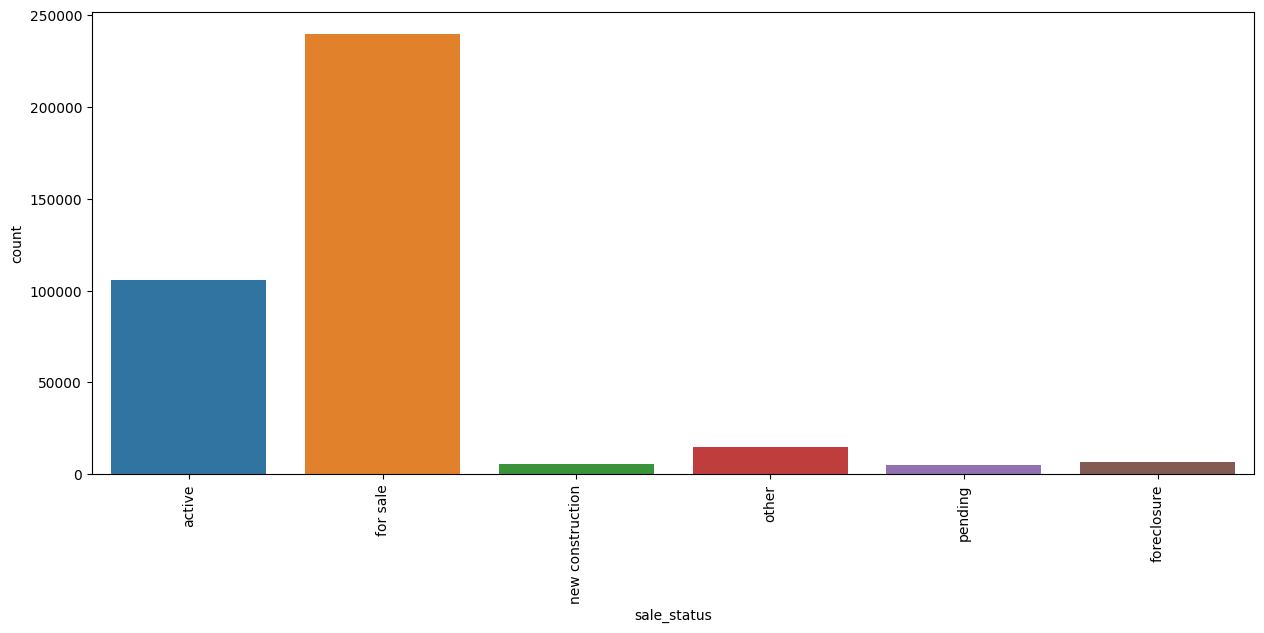

In [262]:
show_feature_info_hist(data['sale_status'])

### Признаки 'PrivatePool' и 'private pool'

In [263]:
data['private pool'].value_counts()

Yes    4181
Name: private pool, dtype: int64

In [264]:
data['PrivatePool'].value_counts()

yes    28793
Yes    11518
Name: PrivatePool, dtype: int64

In [265]:
# сделаем признак бинарным, где 1 будет означать наличие бассейна, а 0 его отсутствие
data['private pool'] = data['private pool'].apply(lambda x: 1 if x=='Yes' else 0)
data['PrivatePool'] = data['PrivatePool'].apply(lambda x: 1 if (x=='Yes' or x=='yes') else 0)

In [266]:
# Объединим два признака:
data['private_pool'] = data['private pool'] | data['PrivatePool']
data.drop(['private pool'], axis=1, inplace=True)
data.drop(['PrivatePool'], axis=1, inplace=True)

In [267]:
data['private_pool'].value_counts()

0    332693
1     44492
Name: private_pool, dtype: int64

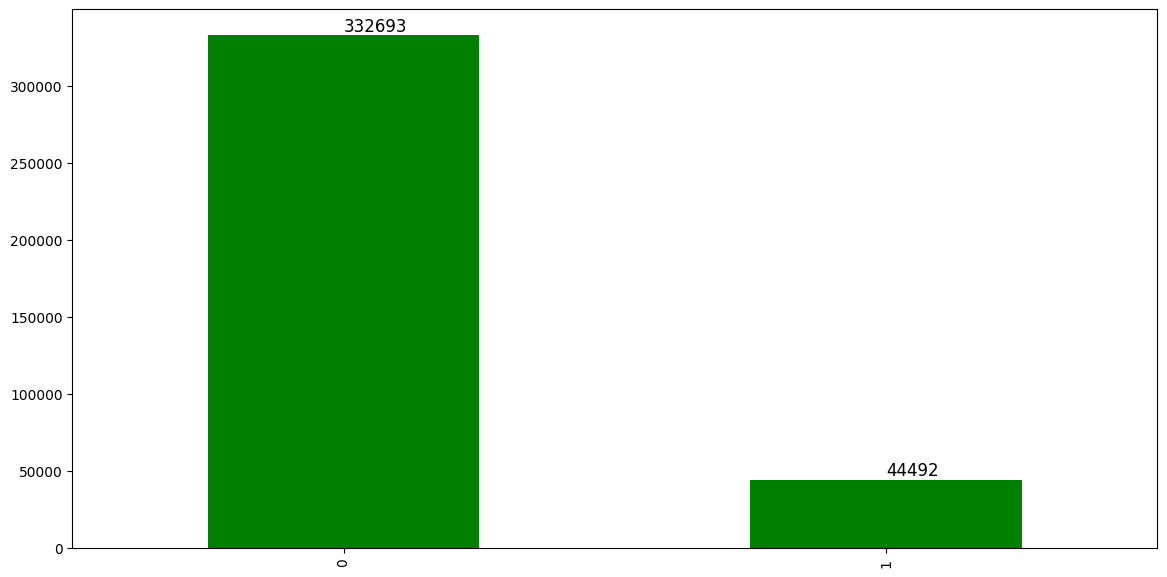

In [268]:
show_plot(data['private_pool'])

### Признак 'propertyType'

In [269]:
show_feature_info(data['propertyType'])

Количество пропусков: 34733

Описание: count                 342452
unique                  1280
top       single-family home
freq                   92206
Name: propertyType, dtype: object

Распределение:
single-family home                                             92206
Single Family                                                  62869
NaN                                                            34733
Single Family Home                                             31728
condo                                                          25968
                                                               ...  
Other, Ranch                                                       1
Traditional, Colonial, Federal                                     1
Condo/Townhome, French, Split Level                                1
Colonial, Duplex                                                   1
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit        1
Name: propertyType, Length: 1281, dt

In [22]:
# data.propertyType.nunique()

In [23]:
# data.propertyType.isna().sum()

Столбец имеет 1280 уникальных значений и 34733 пропуска. Так как пропусков достаточно много, заполним их самым популярным значением 'single-family home'

In [270]:
data.propertyType = data.propertyType.fillna('single-family home')
data.propertyType.value_counts()[:50]

single-family home                  126939
Single Family                        62869
Single Family Home                   31728
condo                                25968
lot/land                             20552
Condo                                16561
townhouse                            11464
Land                                 10934
multi-family                          7900
Condo/Townhome/Row Home/Co-Op         7701
Townhouse                             6936
Traditional                           5913
coop                                  3266
Multi Family                          2794
High Rise                             1823
Ranch                                 1781
mobile/manufactured                   1618
Detached, One Story                   1614
Single Detached, Traditional          1581
Contemporary                          1557
Multi-Family Home                     1501
1 Story                               1234
Colonial                              1205
Mobile / Ma

Некоторые значения имеют различное написание, но одинаковый смысл. Приведём их к единообразию. Для начала приведём всё к нижнему регистру.

In [271]:
data['propertyType'] = data['propertyType'].apply(lambda x: str(x).lower())
data.propertyType.value_counts()[:50]

single-family home                      126939
single family                            62869
condo                                    42529
single family home                       31728
lot/land                                 20552
townhouse                                18400
land                                     10934
multi-family                              7921
condo/townhome/row home/co-op             7701
traditional                               5913
coop                                      3266
multi family                              2794
high rise                                 1823
ranch                                     1781
mobile/manufactured                       1618
detached, one story                       1614
single detached, traditional              1581
contemporary                              1557
multi-family home                         1501
1 story                                   1235
colonial                                  1205
mobile / manu

Содержимое признака небрежно заполнено, данные очень разнообразны и требуют сложного парсинга. Заменим некоторые сокрашенные слова, расшифруем и заменим синонимы на более общепринятые.

In [272]:
old = ['one', 'two', '2-', 'stories', '1 1/2', 'tri-', 'single family',
       'singlefamilyresidence', 'townhome',   'bi', 'bi-', 'multi family', 
       'hi-', 'high ', 'condominium',  '4 plex', 'other', 'ca2 n', 'cape cod',
       'mid century', 'mid-century',  'mo2 le', 'mo2le', ' / ','mfd',   
       'co-op', 'coop',  'modernist', 'key west', 'farm house',
       'queen anne', ' -level', 'floors', 'mobile home', 'manuf/mobile',
       'less than 4 story', 'historic/older', 'quad']
new = ['1', '2', '2 ', 'story',  '1.5', '3 ', 'single-family',
       'single-family', 'townhouse',  '2 ', '2 ',  'multi-family',
       'high-', 'high-', 'condo',  '4-plex', 'other style', 'cabin', 'cape', 
       'midcentury', 'midcentury', 'mobile', 'mobile', '/', 'manufactured', 
        'cooperative', 'cooperative',  'modern', 'elevated', 'farmhouse',
        'victorian', ' level',  'story', 'manufactured', 'manufactured',
        '3 story', 'historical', '4']
for i in range(0,len(new)):
    data['propertyType'] = data['propertyType'].apply(lambda x: 
                                                  x.replace(old[i], new[i]))

In [273]:
data.propertyType.value_counts()[:50]
# data.propertyType.value_counts().index.tolist()

single-family home                             158667
single-family                                   63089
condo                                           42585
lot/land                                        20552
townhouse                                       18400
land                                            10934
multi-family                                    10715
condo/townhouse/row home/cooperativeerative      7701
traditional                                      5913
cooperative                                      3266
mobile/manufactured                              2684
high-rise                                        1839
1 story                                          1827
ranch                                            1781
detached, 1 story                                1614
single detached, traditional                     1581
contemporary                                     1557
2 story                                          1507
multi-family home           

In [274]:
data['propertyType'] = data['propertyType'].apply(lambda x: 'single-family' if (x=='single family') | (x=='single family home') |
                                             (x == 'single-family home') else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'multi-family' if (x=='multi family') | (x == 'multi-family home') else x)
data['propertyType'] = data['propertyType'].apply(lambda x: '1 story' if x=='one story' else x)
data['propertyType'] = data['propertyType'].apply(lambda x: '2 stories' if (x=='2 story') | (x=='two story')  else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'land' if x=='lot/land'  else x)

In [275]:
# data.propertyType.value_counts()[:50]
data.propertyType.value_counts().index.tolist()

['single-family',
 'condo',
 'land',
 'townhouse',
 'multi-family',
 'condo/townhouse/row home/cooperativeerative',
 'traditional',
 'cooperative',
 'mobile/manufactured',
 'high-rise',
 '1 story',
 'ranch',
 'detached, 1 story',
 'single detached, traditional',
 'contemporary',
 '2 stories',
 'colonial',
 'contemporary/modern',
 'apartment',
 'manufactured/manufactured',
 'single detached',
 'detached, 2 story',
 'cooperativeerative',
 'transitional',
 'florida',
 'bungalow',
 'farms/ranches',
 'garden home',
 'cape',
 '2 story, traditional',
 'spanish/mediterranean',
 'other style style',
 '1 story, traditional',
 'other style',
 'condo/townhouse, traditional',
 'craftsman',
 'contemporary/modern, traditional',
 'condo/townhouse',
 'condo/townhouse, contemporary/modern',
 'single detached, contemporary/modern',
 'multiple occupancy',
 '2 story, contemporary',
 'ranch, traditional',
 'mediterranean',
 'traditional, transitional',
 ' ',
 'custom',
 'cluster home',
 'federal',
 'urban c

Строки с обозначением 'land' означают земельный участок, удалим их, так как нас интресует только недвижимость

In [276]:
land_drop = data[data['propertyType']=='land'].index
land_drop

Int64Index([     4,     41,     49,     50,     62,     70,    105,    127,
               143,    178,
            ...
            377079, 377084, 377098, 377101, 377122, 377124, 377128, 377135,
            377140, 377161],
           dtype='int64', length=31486)

In [277]:
data.drop(land_drop,  inplace=True)
data = data.reset_index(drop=True)

В признаке 'propertyType' много сведений об этажности домов. Выделим все  эти данные, тем самым попробуем дополнить признак 'stories'

In [278]:
# Создаем временный признак 'Property_story'
data['Property_story'] = data['propertyType'].apply(lambda x: 
                                        x if -1!= x.find('story') else 'no')

In [279]:
data['Property_story'].value_counts()

no                                                         339493
1 story                                                      1827
detached, 1 story                                            1614
detached, 2 story                                             638
2 story, traditional                                          289
                                                            ...  
1 story, spanish, ranch, traditional                            1
2 story, traditional, mediterranean, texas hill country         1
contemporary/modern, ranch, 1 story                             1
3 story, 4+ story, art deco, multi-level                        1
3+ story, contemporary, traditional                             1
Name: Property_story, Length: 226, dtype: int64

In [280]:
# Выделим индексы строк, имеющие данные об этажности
ind_story = data[data['Property_story']!='no'].index
ind_story

Int64Index([    92,    108,    157,    171,    186,    203,    285,    351,
               496,    544,
            ...
            344768, 344774, 345137, 345146, 345321, 345323, 345415, 345476,
            345602, 345606],
           dtype='int64', length=6206)

In [281]:
data['stories'][ind_story].value_counts()

Multi/Split      26
Three Or More     6
2                 2
1                 2
1 Level           1
Name: stories, dtype: int64

In [282]:
# Оставим сведения относящиеся к этажности и запишем в признак 'stories'
def story(x):
    s = x.split(',')
    se = ''
    for i in range(0, len(s)):
        if s[i].find('story')!=-1:
            se = s[i]
    return se.strip()

data.loc[ind_story, 'stories'] = data['Property_story'][ind_story].apply(story)
data['stories'][ind_story].value_counts()

1 story                    4332
2 story                    1413
1 story with basement        99
low-rise (1-3 story)         90
2 story with basement        68
3 story                      44
3+ story                     44
high-rise (8+ story)         38
1.5 story with basement      21
4+ story                     17
mid-rise (4-7 story)         15
1.5 story                    13
1 story/ranch                 7
manufactured 1 story          1
coastal 2 story               1
2.5 story                     1
2 story condo                 1
1 story traditional           1
Name: stories, dtype: int64

In [283]:
# Очистим от слов, относящихся к типам домов и запишем в признак 'stories'
del_str = ['/ranch', 'manufactured', 'coastal', 'traditional', 'condo']

def del_substr(x):
    for i in range(0, len(del_str)):
        x = x.replace(del_str[i], '').strip()
    return x

data.loc[ind_story, 'stories'] = data['stories'][ind_story].apply(del_substr)
data['stories'][ind_story].value_counts()

1 story                    4341
2 story                    1415
1 story with basement        99
low-rise (1-3 story)         90
2 story with basement        68
3 story                      44
3+ story                     44
high-rise (8+ story)         38
1.5 story with basement      21
4+ story                     17
mid-rise (4-7 story)         15
1.5 story                    13
2.5 story                     1
Name: stories, dtype: int64

In [284]:
# Удаляем сведения, относящихся к этажности для перезаписи в признак 'propertyType'
def type_del_story(x):
    s = x.split(',')
    for i in range(0, len(s)):
        if s[i].find('story')!=-1:
            if len(s)==1 and i==0:
                s[i] = 'other'
            if len(s)>1:
                s[i] = ','
            if len(s)>1 and i==0:
                s[i]=''
        x = '' .join(s).strip()
    return x

data.loc[ind_story, 'propertyType'] = data['Property_story'][ind_story].apply(type_del_story)

data['propertyType'][ind_story].value_counts()

detached,                                   2252
other                                       2135
traditional                                  540
contemporary                                 266
detached, spanish/mediterranean              120
                                            ... 
texas hill country a-frame                     1
colonial contemporary                          1
split level contemporary traditional           1
contemporary ranch traditional craftsman       1
multi-level patio home townhouse               1
Name: propertyType, Length: 127, dtype: int64

In [285]:
# удаляем временный признак
data.drop('Property_story', axis=1, inplace=True)

Далее в полях признака 'propertyType' оставляем основные типы домов, жилищ

In [286]:
# Присвоим полям новые названия в соответствии с найденной подстрокой
new = ['mediterranean', 'english', 'georgian', 'florida','spanish',
        'lake house', 'tudor', 'victorian', 'ranch', 'townhouse', 
        'single-family','multi-family', 'single detached', 'detached', 
        'high-rise', 'colonial', 'traditional',
        'condo', 'contemporary', 'other style', 'bungalow', 'craftsman',
        'cape cod','cooperative', 'a-frame',  'custom', 'loft', 
        'multi-level', 'attached', 'manufactured',  'side-by-side', 
        'cottage',  'french', 'cluster home', 'garden home', 
        'farmhouse', 'elevated',  'historical', 'transitional','penthouse',
        'modern']

for i in range(0, len(new)):
    data['propertyType'] = data['propertyType'].apply(lambda x: new[i] 
                                            if (-1 != x.find(new[i])) else x)

In [287]:
# Присвоим полям новые значения с изменениями
old = ['cape','log']
new = ['cape cod','log home']

for i in range(0,len(new)):
    data['propertyType'] = data['propertyType'].apply(lambda x: new[i] 
                                              if -1!=x.find(old[i])  else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'historical'
                        if (x=='historic') or (x=='historic vintage') else x)

In [288]:
data['propertyType'].value_counts()[:50]

single-family            221756
condo                     42933
townhouse                 27064
multi-family              12218
traditional                7173
detached                   5306
cooperative                3838
manufactured               3516
contemporary               3228
ranch                      3104
other                      2135
high-rise                  1969
2 stories                  1507
colonial                   1343
apartment                   922
mediterranean               875
florida                     749
other style                 640
transitional                569
bungalow                    551
garden home                 321
cape cod                    313
craftsman                   308
multiple occupancy          158
tudor                       156
cluster home                155
custom                      146
victorian                   140
spanish                     129
                            124
modern                      119
split-le

In [289]:
# С целью уменьшения числа категорий, выберем топ 15 стилей домов.
# остальные занесем в категорию 'other'
top_Type = data['propertyType'].value_counts()[:15].index
data['propertyType'] = data['propertyType'].apply(lambda x: x 
                                            if x in top_Type else 'other')

Количество пропусков: 0

Описание: count            345699
unique               15
top       single-family
freq             221756
Name: propertyType, dtype: object

Распределение:
single-family    221756
condo             42933
townhouse         27064
multi-family      12218
other              9822
traditional        7173
detached           5306
cooperative        3838
manufactured       3516
contemporary       3228
ranch              3104
high-rise          1969
2 stories          1507
colonial           1343
apartment           922
Name: propertyType, dtype: int64

Значения: ['single-family' 'townhouse' 'other' 'cooperative' '2 stories'
 'multi-family' 'condo' 'detached' 'ranch' 'colonial' 'high-rise'
 'manufactured' 'contemporary' 'traditional' 'apartment']

Уникальные значения: 15



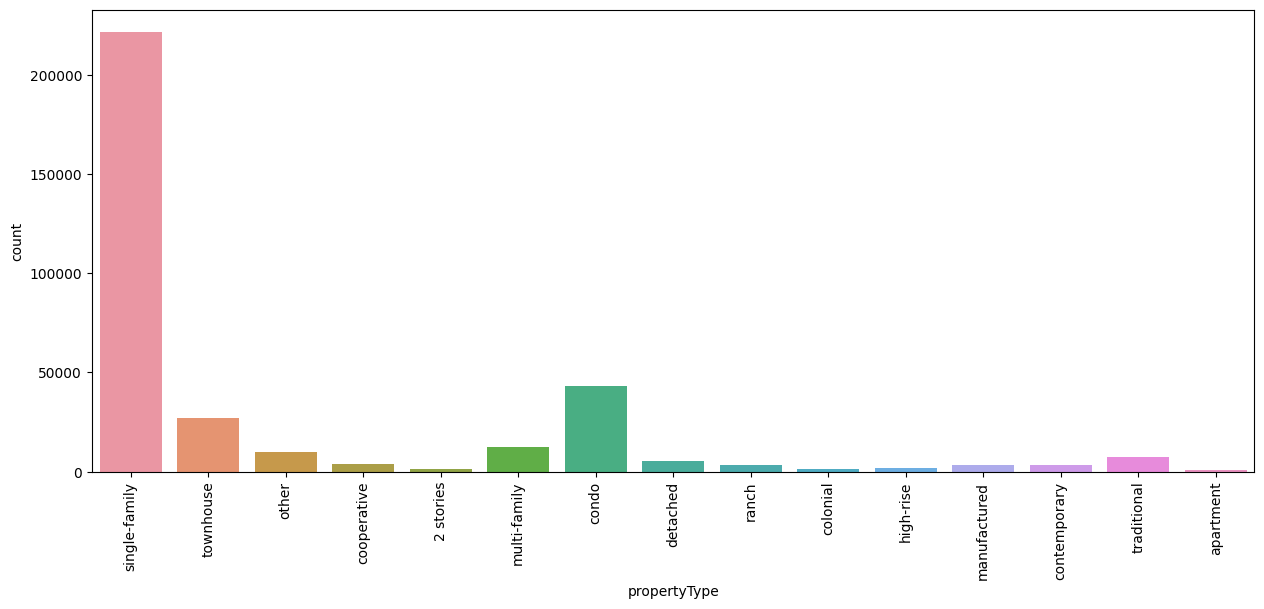

In [290]:
show_feature_info_hist(data['propertyType'])

### Признак 'stories'

In [291]:
show_feature_info(data['stories'])

Количество пропусков: 115637

Описание: count     230062
unique       356
top          1.0
freq       66151
Name: stories, dtype: object

Распределение:
NaN                           115637
1.0                            66151
2.0                            54833
1                              23040
2                              18115
                               ...  
3 Story, Multi Level               1
A Frame                            1
Multi Level, Three or More         1
Quad Level                         1
65.0                               1
Name: stories, Length: 357, dtype: int64

Значения: [nan '2.0' '1.0' '3.0' 'One' '2' 'Multi/Split' '4.0' '0.0' '0' 'One Level'
 '1' '9.0' '2 story' '1 story' '3' '1 Level, Site Built' 'One Story'
 '3.00' '1.00' '14.0' 'Two' '3+' '1 Story' '5.0' '2 Story' 'Ranch/1 Story'
 'Condominium' 'Stories/Levels' '7.0' '2 Level, Site Built' '2 Level' '15'
 '3 Level, Site Built' '4' '22.0' '2.00' '6.0' 'low-rise (1-3 story)'
 '1.0000' '3 Story' 'Thr

Признак имеет 356 уникальных значений и 115637 пропусков.

In [46]:
# data['stories'].value_counts().index.tolist()

In [292]:
data['stories'] = data['stories'].fillna('0.0')
data['stories'] = data['stories'].apply(lambda x: x.lower())
data['stories'] = data['stories'].apply(lambda x: '0.0' if x == '0' else x)

In [293]:
num_str = ['one','two','bi', 'split', 'three','tri','four', 'quad' , 'stories', 
           '-level', 'levels', 'leveland','cape cod', '1 and 1 half', '1 1/2 story',
           'ranch', 'garden', 'log home', 'cape',
          'raised ranch', 'bungalow', 'farm house', '4plex', 'sixplex','tudor']
num_num = ['1','2','2', '2', '3','3', '4', '4', 'story', 
           ' level', 'level', 'level and','1 story', '1.5 story', '1.5 story',
           '1 story', '1 story', '1 story', '1 story',
          '1 story', '1 story', '1 story', '4 plex','6 plex', '2 story']
for i in range(0, len(num_str)):
    data['stories'] = data['stories'].apply(lambda x: x.replace(num_str[i], num_num[i]))

In [49]:
# data['stories'].value_counts().index.tolist()

In [294]:
data['stories'].value_counts()['ca2n/cottage']

4

In [295]:
one_story = ['condominium', 'traditional', 'contemporary', 
             'mo2le', 'ground level', 'modular home', 'craftsman']
def change_story(x):
    if x=='townhouse':
        x = '2'
    if x in one_story:
        x = '1'
    if -1!=x.find('low-rise') or -1!=x.find('multi level'):
        x = '2'
    if -1!=x.find('mid-rise'):
        x = '5'
    if -1!=x.find('high-rise'):
        x = '9'
    return x

data['stories'] = data['stories'].apply(change_story)  

In [296]:
def stories_float(x):
    if x.startswith(','): x = x[1:]
    if x == -1.0: return x
    x = re.sub('[^0-9,-\.]', '', x)
    x = re.sub('-',',', x)
    x = x.replace(',,',',0,')
    x = x.split(',')
    try:
        x = (max([float(item) for item in x]))
        # x = float(x)
        if x>120.0 or x==0.0:
            x=1.0
    except:
        x =1.0
    return x

data['stories'] = data['stories'].apply(stories_float)

In [297]:
data['stories'].describe()

count    345699.000000
mean          1.636387
std           2.364969
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         112.000000
Name: stories, dtype: float64

Посмотрим на значения этажности свыше 100, считаю, что это явные выбросы.

In [298]:
data[data['stories'] > 100]

,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,sale_status,private_pool
9643,single-family,2106 Amur Ct,2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Columbus,"[{'rating': [], 'data': {'Distance': [], 'Grad...",1900,47201,3.0,IN,112.0,NaN,21680892,"$212,000",active,0
178243,single-family,997 Westcreek Dr,3.5,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...","Gas Log Fireplace, Living Room Fireplace",Columbus,"[{'rating': ['7', '5', '6', '8', 'NR', '5', 'N...",4997,47201,5.0,IN,112.0,NaN,21641745,"$799,900",active,0
287481,single-family,6550 W 250 S,4,"{'atAGlanceFacts': [{'factValue': '2000', 'fac...","Family Room Fireplace, Free Standing Wood Stov...",Columbus,"[{'rating': ['7', '5', '6', '8', 'NR', '5', 'N...",4360,47201,3.0,IN,112.0,NaN,21670164,"$639,900",active,0
333734,single-family,3928 State Road 135 N,2,"{'atAGlanceFacts': [{'factValue': '1952', 'fac...","Family Room Fireplace, Gas Log Fireplace, Livi...",Nashville,"[{'rating': ['7', '8', '5', '6', '7', 'NR'], '...",2460,47448,2.0,IN,112.0,NaN,21670068,"$199,000",pending,0


In [299]:
# удалим их
data = data.drop(index=[9643, 178243, 287481, 333734])

### Признак 'street'

In [300]:
show_feature_info(data['street'])

Количество пропусков: 0

Описание: count                    345695
unique                   308978
top       Address Not Disclosed
freq                        632
Name: street, dtype: object

Распределение:
Address Not Disclosed      632
Undisclosed Address        517
(undisclosed Address)      391
Address Not Available      129
Unknown Address             72
                          ... 
14390 Maysville Cir          1
6802 N Pearl St              1
6880 Winged Foot Dr          1
6536 Iron Horse Blvd #1      1
5983 Midcrown Dr             1
Name: street, Length: 308978, dtype: int64

Значения: ['240 Heather Ln' '12911 E Heroy Ave' '2005 Westridge Rd' ...
 '15509 Linden Blvd' '7810 Pereida St' '5983 Midcrown Dr']

Уникальные значения: 308978



Можем наблюдать, что данный признак имеет 308982 уникальных значения. Можно ли извлечь из этого какую полезную информацию? Попробуем...
Переведем все к нижнему регистру и попробуем обработать.

In [301]:
data['street'] = data['street'].apply(lambda x: str(x).lower())

In [58]:
# data['street'].value_counts().head(30)

In [302]:
def av_or_not(st):
    if st == 'address not disclosed' or st == 'undisclosed address' or st=='(undisclosed address)' \
    or st=='address not available' or st=='unknown address': return 'unavailable address'
    else: return st
    
data['street'] = data['street'].apply(lambda x: av_or_not(x))

In [303]:
data['street'].value_counts().head(30)

unavailable address              1741
2103 e state hwy 21                57
11305 gulf fwy                     54
17030 youngblood rd.               38
9470 lancaster rd. sw              32
1 palmer dr                        27
8426 terrace valley circle         25
9845 basil western rd nw           25
6320 sw 89th court road            24
8447 sw 99th street rd             22
5221 s. zapata hwy                 20
whitetail trail                    19
stone bluff drive                  18
3423 heather garden trail          17
1727 opal field lane               17
1365 neihart way                   17
24423 ferdossa drive               17
2005 west happy valley road        17
3435 heather garden trail          17
boncher blvd                       17
50 leanni way                      16
1024 dali blvd.                    16
606 vineyard hollow court          16
11 pheasant drive                  16
9915 camellia gardens drive        15
13410 canterbury castle drive      15
1009 rio de 

Информация в этом признаке является малопригодной для построения модели.
Можно было бы извлечь координаты Latitude/Longitude по адресу (для подсчета расстояния от объекта до центра города или создания более полезного признака), благо на это есть платные сервисы. А вот вручную прогонять все адреса очень времязатратно. Поэтому удалим данный признак.

In [304]:
data.drop('street', axis = 1, inplace = True)

### Признак 'zipcode'

In [305]:
show_feature_info(data['zipcode'])

Количество пропусков: 0

Описание: count     345695
unique      4476
top        33131
freq        1562
Name: zipcode, dtype: object

Распределение:
33131         1562
78245         1388
34747         1335
33132         1327
33137         1298
              ... 
79836            1
27610-2861       1
27613-4042       1
27612-5442       1
64015            1
Name: zipcode, Length: 4476, dtype: int64

Значения: ['28387' '99216' '90049' ... '20191' '48821' '64015']

Уникальные значения: 4476



In [306]:
data.zipcode.sort_values().unique()[:10]

array(['--', '0', '00000', '02108', '02109', '02110', '02111', '02113',
       '02114', '02115'], dtype=object)

In [307]:
# Посмотрим на значения '--'
data[data.zipcode=='--']

,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,sale_status,private_pool
212053,single-family,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Bonsall,"[{'rating': ['7/10', '7/10', '3/10'], 'data': ...",NaN,--,449 acres,CA,1.0,OC19261036,NaN,"$60,000,000",new construction,0
215605,townhouse,3.0,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",NaN,Fort Lauderdale,"[{'rating': ['3/10', '5/10', '7/10'], 'data': ...","2,043",--,3,FL,1.0,NaN,"1744, Fort Lauderdale, FL","$425,000",for sale,0


Запись с индексом 212053 помимо пропуска в 'zipcode', также имеет пропуск 'baths' и 'sqft'. Удалю его.

Запись с индексом 215605 исправим, найдя реальный индекс на карте.

In [308]:
data = data.drop(index=[212053])

In [309]:
data.loc[215605,'zipcode']='33305'

In [310]:
# Посмотрим на значения = '0' и '00000'
data[data.zipcode=='0']

,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,sale_status,private_pool
76591,colonial,NaN,"{'atAGlanceFacts': [{'factValue': '1995', 'fac...",NaN,Quito Ecuador,"[{'rating': [], 'data': {'Distance': [], 'Grad...",NaN,0,NaN,NY,1.0,NaN,3177007,"470,000",other,0


In [311]:
data[data.zipcode=='00000']

,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,sale_status,private_pool
282419,single-family,NaN,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...",NaN,Foreign Country,"[{'rating': [], 'data': {'Distance': [], 'Grad...","1,100",00000,NaN,OS,1.0,NaN,CV18033361,"125,000",active,0


In [312]:
# Удалим их
data = data.drop(index=[76591, 282419])

In [313]:
data.zipcode.sort_values().unique()[:100]

array(['02108', '02109', '02110', '02111', '02113', '02114', '02115',
       '02116', '02118', '02119', '02120', '02121', '02122', '02124',
       '02125', '02126', '02127', '02128', '02129', '02130', '02131',
       '02132', '02134', '02135', '02136', '02199', '02210', '02215',
       '02467', '04666', '04901', '04937', '04957', '04963', '05345',
       '05441', '05441-4400', '05443', '05444', '05445', '05448', '05450',
       '05454', '05455', '05456', '05457', '05461', '05462', '05464',
       '05469', '05472', '05473', '05478', '05482', '05483', '05487',
       '05488', '05491', '05642', '07004', '07004-1106', '07004-1300',
       '07004-1413', '07004-1528', '07004-1607', '07004-1809',
       '07004-1878', '07004-1935', '07004-2116', '07004-2137',
       '07004-2214', '08701', '10001', '10002', '10003', '10004', '10005',
       '10006', '10007', '10009', '10010', '10011', '10012', '10013',
       '10014', '10016', '10017', '10018', '10019', '10021', '10022',
       '10023', '10024'

Наблюдаются индексы из двойных чисел, посмотрим на них

In [314]:
data[data.zipcode.str.contains('.*-.*',na=False, regex=True)]

,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,sale_status,private_pool
3354,other,"1,500","{'atAGlanceFacts': [{'factValue': '1928', 'fac...",1,Raleigh,"[{'rating': ['4', '8', '6'], 'data': {'Distanc...","1,936",27606-1626,Baths,NC,1.0,NaN,2269185,"315,000",active,0
4749,other,"2,500","{'atAGlanceFacts': [{'factValue': '1950', 'fac...",1,Raleigh,"[{'rating': ['6', '7', '5'], 'data': {'Distanc...","1,742",27607-6632,Baths,NC,1.0,NaN,2241307,"475,000",active,0
6560,ranch,"1,750","{'atAGlanceFacts': [{'factValue': '1940', 'fac...",1,Durham,"[{'rating': ['4', '3', '4'], 'data': {'Distanc...","1,194",27705-3261,Baths,NC,1.0,NaN,2281085,"284,900",active,0
6910,traditional,NaN,"{'atAGlanceFacts': [{'factValue': '1986', 'fac...",1,Raleigh,"[{'rating': ['5', '4', '6'], 'data': {'Distanc...","1,674",27603-2692,NaN,NC,1.0,NaN,2292632,"245,000",active,0
7874,other,NaN,"{'atAGlanceFacts': [{'factValue': '2014', 'fac...",3,Raleigh,"[{'rating': ['5', '4', '6'], 'data': {'Distanc...","6,517",27603-3986,NaN,NC,1.0,NaN,2252547,"1,599,000",active,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332896,ranch,NaN,"{'atAGlanceFacts': [{'factValue': '1929', 'fac...",NaN,Raleigh,"[{'rating': ['5', '4', '7'], 'data': {'Distanc...","1,463",27610-5617,NaN,NC,1.0,NaN,2283233,"250,000",active,0
333589,traditional,NaN,"{'atAGlanceFacts': [{'factValue': '1994', 'fac...",1,Raleigh,"[{'rating': ['4', '5', '5'], 'data': {'Distanc...","2,933",27615-3876,NaN,NC,1.0,NaN,2279300,"340,000",active,0
334566,other,NaN,"{'atAGlanceFacts': [{'factValue': '1970', 'fac...",1,Houston,"[{'rating': ['6', '4', '6', '4'], 'data': {'Di...","1,692",77015-2522,NaN,TX,1.0,NaN,13476727,"139,999",active,0
335202,traditional,NaN,"{'atAGlanceFacts': [{'factValue': '1984', 'fac...",1,Raleigh,"[{'rating': ['6', '3', '4'], 'data': {'Distanc...","1,520",27615-6225,NaN,NC,1.0,NaN,2283311,"197,000",active,0


Предполагаю что это какая-то ошибка. Строк всего 240, поэтому обрежу значения, оставив лишь первую часть.

In [315]:
data.zipcode = data.zipcode.str.replace("-.+",'', regex=True)
data.zipcode.nunique()

4244

In [316]:
# Переведем в числовой формат
data.zipcode = data.zipcode.apply(lambda x: int(x))

In [74]:
# data['zipcode'].value_counts().index.tolist()

### Признаки 'mls-id' и 'MlsId'

Не несут в себе информацию, которая бы повлияла на стоимость объекта. Поэтому удалю их.

In [317]:
cols_drop = ['mls-id', 'MlsId']
data.drop(cols_drop, axis=1, inplace=True)

In [318]:
# Сделаем временную копию
data_copy = data.copy()

In [77]:
# data_copy.info()

### Признак 'baths'

In [319]:
show_feature_info(data_copy['baths'])

Количество пропусков: 79162

Описание: count      266530
unique        228
top       2 Baths
freq        52108
Name: baths, dtype: object

Распределение:
NaN           79162
2 Baths       52108
3 Baths       35400
2             20446
2.0           16576
              ...  
4.75 Baths        1
5.25 Baths        1
41.0              1
1.8 Baths         1
44.0              1
Name: baths, Length: 229, dtype: int64

Значения: ['3.5' '3 Baths' '2 Baths' '8 Baths' nan '2' '3' 'Bathrooms: 2' '1,750'
 '4 Baths' '2 ba' 'Bathrooms: 5' '1,000' '7 Baths' '2.0' '3.0'
 'Bathrooms: 1' '4.0' '2.1 Baths' '2.5 Baths' '1' 'Bathrooms: 3' '4.5'
 '6 Baths' 'Bathrooms: 4' '3 ba' '5' '2,500' '5.5 Baths' '1.0' '5 Baths'
 '1.5' '4' '~' '2.5' '4,000' '3.5 Baths' '2,000' '3,000' '8.0' '1 ba'
 '3.5 ba' '5.0' '1,500' '7.0' '1,250' '9 Baths' '2,250' '6.0' '12 Baths'
 '5.5' '3,500' '1.5 Baths' '2,750' 'Bathrooms: 6' '4.5 Baths' '0' '750'
 '5.5+' '6' '10 Baths' '6 ba' 'Bathrooms: 19' '10.0' '1.5 ba' '4 ba'
 '12 ba' '2.5

В столбце 228 уникальных значений и 79162 пропуска.

В результате детального анализа признака можем наблюдать различные способы записей.

Встречаются записи как целые числа, так и через точку и запятую. Если с целыми числами все понятно, то как понять например: 1.1 или 2,5?) Также есть числа разделенные запятой, например: 1,000 или 2,750. Тут вообще не понятно, предполагаю, что это площадь. Еще один из вариантов, запись через /, эти значения удалю.
Остальные приведу к читабельному виду. Пропуски заменим на значение 'no info'.

Проведем анализ некоторых интересных значений

In [320]:
# посмотрим на значение 1,000 в признаке
data_copy[data_copy.baths=='1,000']

,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,sale_status,private_pool
21,other,"1,000","{'atAGlanceFacts': [{'factValue': '1996', 'fac...",NaN,Miami Beach,"[{'rating': ['7', '10', 'NR', '4', '4'], 'data...","1,080",33139,Baths,FL,2.0,"579,000",active,0
25,single-family,"1,000","{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Miami,"[{'rating': ['9', '10', 'NR', '6', '3'], 'data...",NaN,33183,Baths,FL,1.0,"799,000",active,0
342,single-family,"1,000","{'atAGlanceFacts': [{'factValue': '1970', 'fac...",NaN,Miami Beach,"[{'rating': ['5', '10', 'NR', '4', '4'], 'data...",614,33139,Baths,FL,1.0,"179,000",active,0
647,detached,"1,000","{'atAGlanceFacts': [{'factValue': '1993', 'fac...",NaN,Miami,"[{'rating': ['7', '10', 'NR', '3', '3'], 'data...","2,415",33186,Baths,FL,2.0,"410,000",active,0
993,single-family,"1,000","{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Oakland Park,"[{'rating': ['4', '4', '2'], 'data': {'Distanc...",NaN,33309,Baths,FL,1.0,"375,000",active,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343886,detached,"1,000","{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Dallas,"[{'rating': ['6', '3', '3', '10'], 'data': {'D...","2,022",75209,Baths,TX,1.0,"590,000",active,0
344124,detached,"1,000","{'atAGlanceFacts': [{'factValue': '2000', 'fac...",NaN,Miami,"[{'rating': ['7', '10', 'NR', '3', '3'], 'data...","1,621",33186,Baths,FL,1.0,"434,900",active,0
345128,single-family,"1,000","{'atAGlanceFacts': [{'factValue': '1962', 'fac...",NaN,Oakland Park,"[{'rating': ['1', '3', '3'], 'data': {'Distanc...","1,388",33309,Baths,FL,1.0,"359,999",active,0
345347,single-family,"1,000","{'atAGlanceFacts': [{'factValue': '1935', 'fac...",NaN,Miami Beach,"[{'rating': ['5', '10', 'NR', '4', '4'], 'data...",830,33139,Baths,FL,1.0,"245,000",active,0


Заметил интересные записи, например в индексе 21: общая площать объекта 1,080 sqft из них 1,000 ванная комната. Или например индекс 343886: площадь объекта 2,022 из них 1,000 ванная комната. Или вообще: индекс 345674, у которого площадь объекта 920, а ванная комната 1,000.

Отсюда делаю предположение, что это не площать ванной комнаты, а просто значение, которое записано с тремя нулами и это ошибка записи. В последующем избавимся от них.

Также обратил внимание на значение в признаке 'beds', везде оно как-то странно записано: 'Nan' или 'Baths'?!

In [321]:
# посмотрим на значение 3,000 в признаке
data_copy[data_copy.baths=='3,000']

,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,sale_status,private_pool
199,single-family,"3,000","{'atAGlanceFacts': [{'factValue': '2019', 'fac...",2,Nashville,"[{'rating': ['9', '8', '9'], 'data': {'Distanc...","3,671",37221,Baths,TN,1.0,"946,900",active,0
911,other,"3,000","{'atAGlanceFacts': [{'factValue': '1951', 'fac...",NaN,Charlotte,"[{'rating': ['6', '2', '4'], 'data': {'Distanc...","1,927",28205,Baths,NC,1.0,"485,000",active,0
1117,traditional,"3,000","{'atAGlanceFacts': [{'factValue': '1955', 'fac...",NaN,Houston,"[{'rating': ['8', '7', '6'], 'data': {'Distanc...","1,931",77096,Baths,TX,1.0,"499,000",active,0
1171,other,"3,000","{'atAGlanceFacts': [{'factValue': '1966', 'fac...",NaN,Charlotte,"[{'rating': ['5', '2', '4'], 'data': {'Distanc...","1,203",28205,Baths,NC,1.0,"230,000",active,0
1595,traditional,"3,000","{'atAGlanceFacts': [{'factValue': '1965', 'fac...",1,Houston,"[{'rating': ['4', '5', '2'], 'data': {'Distanc...","2,944",77096,Baths,TX,1.0,"299,999",active,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344701,detached,"3,000","{'atAGlanceFacts': [{'factValue': '2005', 'fac...",NaN,Dallas,"[{'rating': ['1', '3', '1', '10'], 'data': {'D...","1,348",75223,Baths,TX,1.0,"199,900",active,0
345061,single-family,"3,000","{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Austin,"[{'rating': ['3', '5', '4'], 'data': {'Distanc...","1,997",78704,Baths,TX,2.0,"824,900",active,0
345189,traditional,"3,000","{'atAGlanceFacts': [{'factValue': '1967', 'fac...",NaN,Houston,"[{'rating': ['6', '5', '1'], 'data': {'Distanc...","1,052",77063,Baths,TX,1.0,"165,000",active,0
345236,ranch,"3,000","{'atAGlanceFacts': [{'factValue': '1961', 'fac...",NaN,Houston,"[{'rating': ['9', '7', '2'], 'data': {'Distanc...","2,239",77096,Baths,TX,1.0,"390,000",active,0


Предполагаю, что данное значение тоже записано с тремя нулями, считаю это ошибкой ввода, будем избавляться.

In [322]:
# посмотрим на значение 68 Baths в признаке
data_copy[data_copy.baths=='68 Baths']

,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,sale_status,private_pool
311913,multi-family,68 Baths,"{'atAGlanceFacts': [{'factValue': '1983', 'fac...",NaN,Sunland,"[{'rating': ['6/10', '5/10', '6/10'], 'data': ...","37,394 sqft",91040,76 Beds,CA,2.0,"$12,800,000",for sale,0


Тут похоже на правду! Площадь объекта 37,394 sqft. Имеет 76 спален (ох уж эти американцы, любят роскошь) и 68 ванных комнат. Оставим как есть.

In [323]:
# посмотрим на значение 44.0 в признаке
data_copy[data_copy.baths=='44.0']

,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,sale_status,private_pool
330831,multi-family,44.0,"{'atAGlanceFacts': [{'factValue': '1910', 'fac...",NaN,Boston,"[{'rating': ['2/10', '9/10'], 'data': {'Distan...","21,210",2120,78,MA,1.0,"$20,000,000",for sale,0


Похоже на правду.

In [324]:
# посмотрим на значение 7,500+ в признаке
data_copy[data_copy.baths=='7,500+']

,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,sale_status,private_pool
18347,detached,"7,500+","{'atAGlanceFacts': [{'factValue': '1966', 'fac...",1,Dallas,"[{'rating': ['9', '10', '7', '7', '7', '7', '5...","1,502",75240,Baths,TX,1.0,"285,000",active,0
31860,detached,"7,500+","{'atAGlanceFacts': [{'factValue': '1960', 'fac...",1,Dallas,"[{'rating': ['7', '3', '4', '10'], 'data': {'D...","2,636",75240,Baths,TX,1.0,"410,000",active,0
84607,detached,"7,500+","{'atAGlanceFacts': [{'factValue': '1998', 'fac...",2,Dallas,"[{'rating': ['5', '9', '7', '7', '7', '5'], 'd...","3,760",75240,Baths,TX,1.0,"399,700",active,0
97677,townhouse,"7,500+","{'atAGlanceFacts': [{'factValue': '1981', 'fac...",1,Dallas,"[{'rating': ['7', '3', '4', '10'], 'data': {'D...","1,211",75254,Baths,TX,1.0,"159,000",active,0
108837,other,"7,500+","{'atAGlanceFacts': [{'factValue': '2006', 'fac...",1,Dallas,"[{'rating': ['6', '3', '3', '10'], 'data': {'D...","2,172",75240,Baths,TX,1.0,"415,000",active,0
116424,townhouse,"7,500+","{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Dallas,"[{'rating': ['5', '9', '7', '7', '7', '5'], 'd...","1,293",75240,Baths,TX,1.0,"299,900",active,0
124760,townhouse,"7,500+","{'atAGlanceFacts': [{'factValue': '1981', 'fac...",1,Dallas,"[{'rating': ['7', '3', '4', '10'], 'data': {'D...","1,084",75254,Baths,TX,1.0,"124,900",active,0
133838,detached,"7,500+","{'atAGlanceFacts': [{'factValue': '1969', 'fac...",1,Dallas,"[{'rating': ['5', '9', '7', '7', '7', '5'], 'd...","2,218",75240,Baths,TX,1.0,"269,000",active,0
163196,detached,"7,500+","{'atAGlanceFacts': [{'factValue': '1964', 'fac...",1,Dallas,"[{'rating': ['5', '9', '7', '7', '7', '5'], 'd...","1,986",75240,Baths,TX,1.0,"274,500",active,0
164554,townhouse,"7,500+","{'atAGlanceFacts': [{'factValue': '1968', 'fac...",NaN,Dallas,"[{'rating': ['7', '3', '4', '10'], 'data': {'D...",719,75230,Baths,TX,1.0,"85,000",active,0


Тут значение 7,500+ не является площадью ванной комнаты. Предполагаю, что это также заполение с лишними нулями. По площади объекта недвижимости мало похоже на правду. Также снова в каждом индексе признак 'beds' записан как то не понятно.

In [325]:
data_copy[data_copy.baths=='750']

,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,sale_status,private_pool
1027,traditional,750,"{'atAGlanceFacts': [{'factValue': '1993', 'fac...",1,Dallas,"[{'rating': ['5', '5', '2', '10'], 'data': {'D...","1,758",75219,Baths,TX,1.0,"499,000",active,0
1871,single-family,750,"{'atAGlanceFacts': [{'factValue': '2013', 'fac...",NaN,Washington,"[{'rating': ['8', '8', '3', '8'], 'data': {'Di...","1,367",20001,NaN,DC,1.0,"1,499,000",active,0
3300,single-family,750,"{'atAGlanceFacts': [{'factValue': '1981', 'fac...",NaN,DENVER,"[{'rating': ['5', 'NR', '5', '2'], 'data': {'D...",873,80204,Baths,CO,1.0,"348,900",active,0
6926,single-family,750,"{'atAGlanceFacts': [{'factValue': '1936', 'fac...",NaN,DENVER,"[{'rating': ['2', '2', '2'], 'data': {'Distanc...","1,864",80204,Baths,CO,1.0,"560,000",active,0
7045,townhouse,750,"{'atAGlanceFacts': [{'factValue': '1984', 'fac...",3,Dallas,"[{'rating': ['4', '3', '2', '10'], 'data': {'D...","1,336",75219,Baths,TX,3.0,"285,000",active,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341461,single-family,750,"{'atAGlanceFacts': [{'factValue': '1991', 'fac...",NaN,Washington,"[{'rating': ['8', '8', '3', '5'], 'data': {'Di...",801,20004,NaN,DC,1.0,"449,000",active,0
344264,townhouse,750,"{'atAGlanceFacts': [{'factValue': '1998', 'fac...",NaN,Dallas,"[{'rating': ['5', '5', '2', '10'], 'data': {'D...",832,75219,Baths,TX,1.0,"219,500",active,0
344618,townhouse,750,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Dallas,"[{'rating': ['4', '3', '2', '10'], 'data': {'D...","2,102",75219,Baths,TX,1.0,"464,900",active,0
344744,townhouse,750,"{'atAGlanceFacts': [{'factValue': '1998', 'fac...",NaN,Dallas,"[{'rating': ['5', '5', '2', '10'], 'data': {'D...",837,75219,Baths,TX,22.0,"240,000",active,0


Изучив признак досконально прихожу к выводу, что данный признак заполнялся как попало. Попробуем преобразовать его в читабельный и компактный вид.

In [326]:
data_copy.baths.sort_values().unique()

array(['-- baths', '0', '0 / 0', '0.0', '0.00', '0.75 Baths', '1',
       '1 / 1 / 1 / 1', '1 / 1-0 / 1-0 / 1-0', '1 ba', '1,000', '1,250',
       '1,500', '1,750', '1-0 / 1-0 / 1', '1-2 Baths', '1.0', '1.1 Baths',
       '1.25 Baths', '1.5', '1.5 Baths', '1.5 ba', '1.5+', '1.75 Baths',
       '1.75 ba', '1.8 Baths', '10', '10 Baths', '10 ba', '10.0', '10.5',
       '10.5 Baths', '10.5+', '11', '11 Baths', '11 ba', '11.0',
       '11.5 Baths', '11.5+', '116 / 116 / 116', '12', '12 Baths',
       '12 ba', '12.0', '12.5', '12.5+', '13', '13 Baths', '13 ba',
       '13.0', '14', '14 Baths', '14.0', '14.5+', '15', '15 Baths',
       '15.0', '16', '16 Baths', '16 ba', '16.0', '17', '17 Baths',
       '17.0', '18', '18 Baths', '18.0', '19 Baths', '2', '2 Baths',
       '2 ba', '2 baths', '2,000', '2,250', '2,500', '2,750',
       '2-1 / 2-1 / 1-1 / 1-1', '2.0', '2.1 Baths', '2.2 Baths',
       '2.25 Baths', '2.25 ba', '2.5', '2.5 Baths', '2.5 ba', '2.5+',
       '2.75 Baths', '2.8 Baths', '2

In [327]:
# Приведем все к нижнему регистру
data_copy['baths'] = data_copy['baths'].apply(lambda x: str(x).lower())

In [328]:
# Удалим все буквы, поскольку нам важно только количество
data_copy.baths = data_copy.baths.str.replace('[a-zA-Z]','', regex=True)
# Удалим все пробелы
data_copy.baths = data_copy.baths.str.replace(' ','', regex=True)
# Удалим все :
data_copy.baths = data_copy.baths.str.replace(':','', regex=True)
# Удалим все + 
data_copy.baths = data_copy.baths.str.replace('+','', regex=True)
# Заменим , на .
data_copy.baths = data_copy.baths.str.replace(',','.', regex=True)

In [88]:
# data_copy.baths.sort_values().unique()

In [329]:
data_copy.baths = data_copy.baths.fillna('no info')
data_copy.baths = data_copy.baths \
.str.replace('~','no info', regex=True) \
.str.replace('\.\.','no info', regex=True) \
.str.replace('--','2', regex=True) \
.str.replace('—','2', regex=True) \
.str.replace('^\s*$','2', regex=True) \
.str.replace('1-0/1-0/1','4', regex=True) \
.str.replace('116/116/116','116', regex=True) \
.str.replace('3-1/2-2','3', regex=True) \
.str.replace('1/1/1/1','4', regex=True) \
.str.replace('1/4','4', regex=True) \
.str.replace('2-1/2-1/1-1/1-1','4', regex=True) \
.str.replace('1/1-0/1-0/1-0','2', regex=True) \
.str.replace('.*no info.*','no info', regex=True) \
.str.replace('1-2','2', regex=True) \
.str.replace('^0.0+','0', regex=True)

In [330]:
data_copy.baths.sort_values().unique()

array(['0', '0.75', '1', '1.0', '1.000', '1.1', '1.25', '1.250', '1.5',
       '1.500', '1.75', '1.750', '1.8', '10', '10.0', '10.5', '11',
       '11.0', '11.5', '116', '12', '12.0', '12.5', '13', '13.0', '14',
       '14.0', '14.5', '15', '15.0', '16', '16.0', '17', '17.0', '18',
       '18.0', '19', '2', '2.0', '2.000', '2.1', '2.2', '2.25', '2.250',
       '2.5', '2.500', '2.75', '2.750', '2.8', '20', '20.0', '21', '22',
       '22.0', '23', '23.0', '24', '24.0', '241', '25', '26', '27', '28',
       '29', '3', '3.0', '3.000', '3.1', '3.2', '3.25', '3.3', '3.5',
       '3.500', '3.75', '30', '30.0', '32', '34', '34.0', '35', '36',
       '39', '4', '4-0', '4.0', '4.000', '4.1', '4.25', '4.5', '4.75',
       '40', '41.0', '42', '43', '44', '44.0', '5', '5.0', '5.000', '5.2',
       '5.25', '5.5', '55.0', '6', '6.0', '6.5', '6.75', '60', '64.0',
       '68', '7', '7.0', '7.5', '7.500', '750', '76', '8', '8.0', '8.5',
       '9', '9.0', '9.5', 'no info'], dtype=object)

Делаю предположение, что значение целого числа и дробного это одно и тоже. Поэтому объединим их.

Значение поля 241 в признаке по всей вероятности опечатка, так как является домом с 4-мя спальнями для одной семьи. Поэтому ставим 4 вместо 241.

In [331]:
data_copy.baths = data_copy.baths \
.str.replace('23.0','23', regex=True) \
.str.replace('44.0','44', regex=True) \
.str.replace('34.0','34', regex=True) \
.str.replace('30.0','30', regex=True) \
.str.replace('24.0','24', regex=True) \
.str.replace('241','4', regex=True) \
.str.replace('22.0','22', regex=True) \
.str.replace('20.0','20', regex=True) \
.str.replace('18.0','18', regex=True) \
.str.replace('17.0','17', regex=True) \
.str.replace('16.0','16', regex=True) \
.str.replace('15.0','15', regex=True) \
.str.replace('14.0','14', regex=True) \
.str.replace('13.0','13', regex=True) \
.str.replace('12.0','12', regex=True) \
.str.replace('11.0','11', regex=True) \
.str.replace('10.0','10', regex=True)

In [332]:
data_copy['baths'].value_counts().index.tolist()

['2',
 '3',
 '4',
 '2.0',
 '2.5',
 '3.0',
 '1',
 '5',
 '1.0',
 '3.5',
 '4.0',
 '6',
 '1.500',
 '1.5',
 '2.000',
 '1.750',
 '7',
 '3.000',
 '4.5',
 '5.0',
 '2.250',
 '1.000',
 '1.250',
 'no info',
 '2.750',
 '8',
 '2.500',
 '6.0',
 '3.500',
 '5.5',
 '9',
 '7.0',
 '10',
 '4.000',
 '750',
 '5.000',
 '8.0',
 '0',
 '6.5',
 '11',
 '12',
 '9.0',
 '1.75',
 '13',
 '7.5',
 '2.1',
 '16',
 '14',
 '2.75',
 '18',
 '8.5',
 '15',
 '7.500',
 '1.1',
 '24',
 '20',
 '2.25',
 '10.5',
 '3.1',
 '17',
 '3.25',
 '22',
 '26',
 '1.25',
 '3.75',
 '23',
 '30',
 '9.5',
 '27',
 '21',
 '12.5',
 '40',
 '19',
 '36',
 '11.5',
 '4.1',
 '32',
 '44',
 '4.25',
 '3.2',
 '29',
 '28',
 '34',
 '2.2',
 '0.75',
 '2.8',
 '4-0',
 '64.0',
 '60',
 '6.75',
 '39',
 '42',
 '55.0',
 '1.8',
 '41.0',
 '5.25',
 '4.75',
 '25',
 '43',
 '3.3',
 '76',
 '14.5',
 '5.2',
 '116',
 '35',
 '68']

In [333]:
data_copy.baths = data_copy.baths \
.str.replace('9.0','9', regex=True) \
.str.replace('8.0','8', regex=True) \
.str.replace('7.0','7', regex=True) \
.str.replace('6.0','6', regex=True) \
.str.replace('5.0','5', regex=True) \
.str.replace('4.0','4', regex=True) \
.str.replace('3.0','3', regex=True) \
.str.replace('2.0','2', regex=True) \
.str.replace('1.0','1', regex=True)

In [334]:
data_copy['baths'].value_counts().index.tolist()

['2',
 '3',
 '4',
 '1',
 '2.5',
 '5',
 '3.5',
 '1.5',
 '6',
 '7',
 '200',
 '1.7',
 '300',
 '4.5',
 '2.2',
 '100',
 '1.2',
 '8',
 'no info',
 '2.7',
 '9',
 '5.5',
 '10',
 '400',
 '500',
 '0',
 '6.5',
 '11',
 '12',
 '1.75',
 '7.5',
 '13',
 '2.1',
 '16',
 '14',
 '2.75',
 '18',
 '8.5',
 '15',
 '1.1',
 '24',
 '20',
 '2.25',
 '10.5',
 '3.1',
 '3.25',
 '22',
 '17',
 '23',
 '26',
 '3.75',
 '1.25',
 '30',
 '9.5',
 '27',
 '21',
 '12.5',
 '40',
 '36',
 '44',
 '32',
 '4.1',
 '11.5',
 '19',
 '0.75',
 '28',
 '29',
 '34',
 '3.2',
 '4.25',
 '60',
 '6.75',
 '64',
 '1.8',
 '39',
 '42',
 '2.8',
 '25',
 '41',
 '5.25',
 '4.75',
 '55',
 '43',
 '3.3',
 '76',
 '14.5',
 '5.2',
 '116',
 '35',
 '68']

In [335]:
# Заменим значения с тремя нулями и тысячными долями до вменяемых
data_copy.baths = data_copy.baths \
.str.replace('7.500','7.5', regex=True) \
.str.replace('5.000','5', regex=True) \
.str.replace('4.000','4', regex=True) \
.str.replace('3.500','3.5', regex=True) \
.str.replace('3.000','3', regex=True) \
.str.replace('2.750','2.75', regex=True) \
.str.replace('2.500','2.5', regex=True) \
.str.replace('2.250','2.25', regex=True) \
.str.replace('2.000','2', regex=True) \
.str.replace('1.750','1.75', regex=True) \
.str.replace('1.500','1.5', regex=True) \
.str.replace('1.250','1.25', regex=True) \
.str.replace('1.000','1', regex=True) \
.str.replace('750','7.5', regex=True)

In [96]:
# data_copy['baths'].value_counts().index.tolist()

### Уважаемые Менторы! Прошу пояснить, откуда взялись следующие значения (500, 400, 300, 200, 100) ниже в признаке? До этого их не было...что делаю не правильно. Честно, глаз уже замылился, весь день просидел над этим признаком(

In [336]:
data_copy.baths = data_copy.baths \
.str.replace('100','1', regex=True) \
.str.replace('200','2', regex=True) \
.str.replace('300','3', regex=True) \
.str.replace('400','4', regex=True) \
.str.replace('500','5', regex=True)

In [337]:
data_copy['baths'].value_counts()[:10]

2      182833
3       66577
4       26291
1       17779
2.5     13768
5        9441
3.5      6153
1.5      4338
6        4299
7        2310
Name: baths, dtype: int64

In [338]:
# С целью уменьшения числа категорий, выберем топ 10 значений.
# остальные занесем в категорию 'other'
top_baths = data_copy['baths'].value_counts()[:10].index
data_copy['baths'] = data_copy['baths'].apply(lambda x: x 
                                            if x in top_baths else 'other')

In [339]:
data_copy['baths'].value_counts()

2        182833
3         66577
4         26291
1         17779
2.5       13768
other     11903
5          9441
3.5        6153
1.5        4338
6          4299
7          2310
Name: baths, dtype: int64

Количество пропусков: 0

Описание: count     345692
unique        11
top            2
freq      182833
Name: baths, dtype: object

Распределение:
2        182833
3         66577
4         26291
1         17779
2.5       13768
other     11903
5          9441
3.5        6153
1.5        4338
6          4299
7          2310
Name: baths, dtype: int64

Значения: ['3.5' '3' '2' 'other' '4' '5' '1' '7' '2.5' '6' '1.5']

Уникальные значения: 11



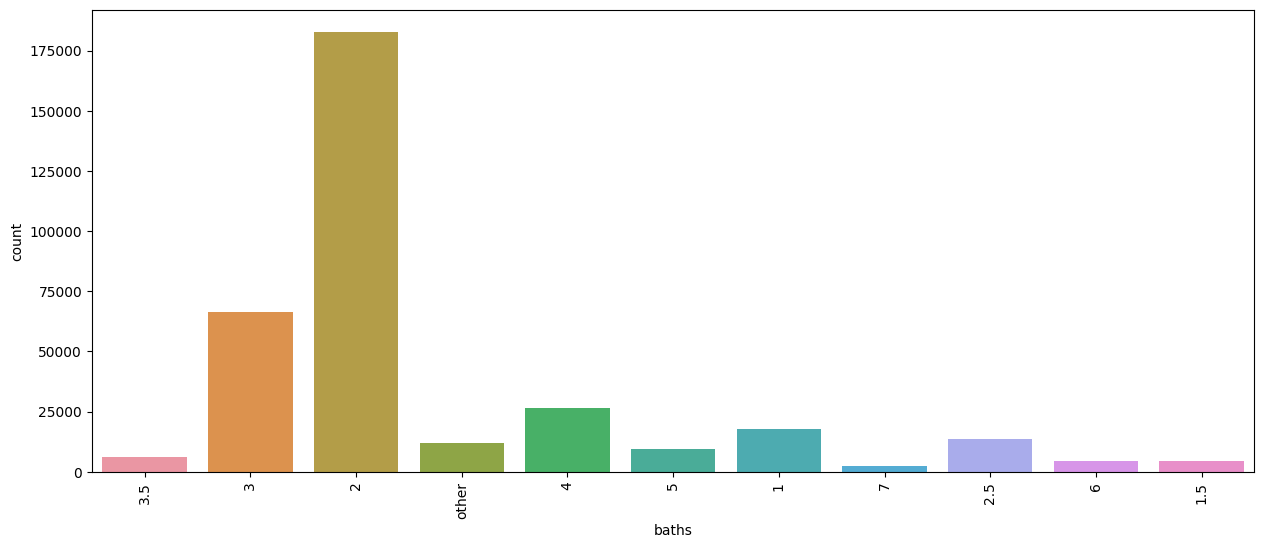

In [340]:
show_feature_info_hist(data_copy['baths'])

### Признак 'homeFacts'

In [341]:
data_copy['homeFacts'].value_counts()

{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '—', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}                                                             7168
{'atAGlanceFacts': [{'factValue': None, 'factLabel': 'Year built'}, {'factValue': None, 'factLabel': 'Remodeled year'}, {'factValue': None, 'factLabel': 'Heating'}, {'factValue': None, 'factLabel': 'Cooling'}, {'factValue': None, 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}                                                  3532
{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Coo

In [103]:
# data.homeFacts.nunique()

In [104]:
# data.homeFacts.isna().sum()

In [342]:
data_copy.homeFacts[0]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

Как можем заметить, типом данных является строка, в которой закодирован словарь. Применим функцию eval для раскодировки словаря.

In [343]:
data_copy.homeFacts = data_copy.homeFacts.apply(eval)

In [344]:
data_copy.homeFacts[0]

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'},
  {'factValue': '', 'factLabel': 'Remodeled year'},
  {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'},
  {'factValue': '', 'factLabel': 'Cooling'},
  {'factValue': '', 'factLabel': 'Parking'},
  {'factValue': None, 'factLabel': 'lotsize'},
  {'factValue': '$144', 'factLabel': 'Price/sqft'}]}

In [345]:
# Извлечем из словаря год постройки дома и создадим новый признак 'year_built'.
data_copy['year_built'] = data_copy['homeFacts'].apply(lambda x: x['atAGlanceFacts'][0]['factValue'])

In [346]:
show_feature_info(data_copy['year_built'])

Количество пропусков: 3613

Описание: count     342079
unique       228
top         2019
freq       32051
Name: year_built, dtype: object

Распределение:
2019    32051
        31781
2006     7982
2005     7478
2007     7110
        ...  
1780        1
1809        1
1823        1
1807        1
1804        1
Name: year_built, Length: 229, dtype: int64

Значения: ['2019' '1961' '2006' '1920' '1976' '1970' '1965' '2015' '1996' '1982'
 '1905' '2008' '1899' '2016' '1954' '1989' '2014' '1915' '' '1994' '1910'
 '1923' '1960' '1977' '1972' '1963' '1981' '1949' '1930' '1991' '1958'
 '2005' '2017' '2018' '1983' '1928' '1998' '1997' '1964' '1940' '1973'
 '1968' '1999' '1918' '2007' '1984' '1946' '2003' '2000' '2004' '1969'
 '2002' '1952' '1974' '1947' '1957' '1978' '1956' '1967' '1975' '1988'
 '1955' '1950' '1959' '2012' '1924' '1966' '1992' '2001' '1995' '1985'
 '2010' '1971' '1909' '1953' '1993' '1990' '1980' '1951' '1907' '1885'
 '1941' '1927' '1929' '1901' None '1922' '1906' '1945' '1979' '200

In [110]:
# data_copy.year_built.isna().sum()

In [111]:
# data_copy.year_built.unique()

Столбец содержит 228 уникальных значения и 3613 пропусков. Видны некорректные значения. Проведем обработку этих данных. В столбце есть строки со значениями 559990649990 и 1. Удалим их.



In [347]:
data_copy = data_copy.drop(data_copy[(data_copy.year_built == '559990649990') | (data_copy.year_built == '1')].index)
data_copy.reset_index(inplace = True, drop = True)

Пустая строка ' ' означает пропуск, также пропуск означает строка 'No Data' и значение None. Сначала заменим ' ' и 'No Data' на None.

In [348]:
data_copy.year_built = data_copy.year_built.apply(lambda x: None if (x == '') | (x == 'No Data') else x)

In [349]:
data_copy.year_built.unique()

array(['2019', '1961', '2006', '1920', '1976', '1970', '1965', '2015',
       '1996', '1982', '1905', '2008', '1899', '2016', '1954', '1989',
       '2014', '1915', None, '1994', '1910', '1923', '1960', '1977',
       '1972', '1963', '1981', '1949', '1930', '1991', '1958', '2005',
       '2017', '2018', '1983', '1928', '1998', '1997', '1964', '1940',
       '1973', '1968', '1999', '1918', '2007', '1984', '1946', '2003',
       '2000', '2004', '1969', '2002', '1952', '1974', '1947', '1957',
       '1978', '1956', '1967', '1975', '1988', '1955', '1950', '1959',
       '2012', '1924', '1966', '1992', '2001', '1995', '1985', '2010',
       '1971', '1909', '1953', '1993', '1990', '1980', '1951', '1907',
       '1885', '1941', '1927', '1929', '1901', '1922', '1906', '1945',
       '1979', '2009', '1962', '1913', '2011', '1897', '1987', '2020',
       '1926', '1939', '1925', '2013', '1986', '1943', '1935', '1890',
       '1900', '1895', '1911', '1948', '1942', '1916', '1931', '1944',
       '

In [350]:
data_copy[(data_copy['year_built']> '0') & (data_copy['year_built']< '1700')]

,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,sale_status,private_pool,year_built
137391,single-family,2,"{'atAGlanceFacts': [{'factValue': '1208', 'fac...",NaN,Logan,"[{'rating': ['9', '6', '4', '6', 'NR', 'NR'], ...",1208,43138,3.0,OH,1.0,"$79,000",other,0,1208
158313,single-family,2,"{'atAGlanceFacts': [{'factValue': '1057', 'fac...",NaN,Ocala,"[{'rating': ['1', '4', '3', '1', '6', '5', 'NR...",1042,34482,2,FL,1.0,"$104,900",active,0,1057
242084,single-family,2,"{'atAGlanceFacts': [{'factValue': '1060', 'fac...",NaN,Brooklyn,"[{'rating': ['6', '8', '5', '6'], 'data': {'Di...","1,892",11218,NaN,NY,1.0,"1,499,999",active,0,1060
286675,other,3,"{'atAGlanceFacts': [{'factValue': '1019', 'fac...",NaN,Charlotte,"[{'rating': [], 'data': {'Distance': [], 'Grad...","1,811",28216,Baths,NC,1.0,"285,500",active,0,1019


Как видим, есть 4 объекта с некорректной датой постройки. Предполагаю что это ошибка ввода символа в значениях 1057, 1060, 1019 - вместо 9 нажали на 0.

Объект с датой постройки 1208 удалю.

In [351]:
data_copy[(data_copy['year_built']> '2022')]

,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,sale_status,private_pool,year_built
150440,traditional,2,"{'atAGlanceFacts': [{'factValue': '2025', 'fac...",1,Raleigh,"[{'rating': ['5', '4', '3'], 'data': {'Distanc...","3,518",27603,NaN,NC,1.0,"534,000",active,0,2025
287264,traditional,2,"{'atAGlanceFacts': [{'factValue': '2025', 'fac...",1,Raleigh,"[{'rating': ['5', '4', '3'], 'data': {'Distanc...","3,000",27603,NaN,NC,1.0,"494,990",active,0,2025


Также удалю эти строки.

In [352]:
# Заменим 0 на 9
data_copy.loc[data_copy['year_built']=='1019','year_built'] = '1919'
data_copy.loc[data_copy['year_built']=='1057','year_built'] = '1957'
data_copy.loc[data_copy['year_built']=='1060','year_built'] = '1960'

In [353]:
# Удаляю строки с индексрм 137391 у которой дата постройки 1208 год
# а также строки с индексом 150440 и 287264 с датой постройки 2025 год
data_copy = data_copy.drop(index=[137391, 150440, 287264])

In [354]:
data_copy.year_built.unique()

array(['2019', '1961', '2006', '1920', '1976', '1970', '1965', '2015',
       '1996', '1982', '1905', '2008', '1899', '2016', '1954', '1989',
       '2014', '1915', None, '1994', '1910', '1923', '1960', '1977',
       '1972', '1963', '1981', '1949', '1930', '1991', '1958', '2005',
       '2017', '2018', '1983', '1928', '1998', '1997', '1964', '1940',
       '1973', '1968', '1999', '1918', '2007', '1984', '1946', '2003',
       '2000', '2004', '1969', '2002', '1952', '1974', '1947', '1957',
       '1978', '1956', '1967', '1975', '1988', '1955', '1950', '1959',
       '2012', '1924', '1966', '1992', '2001', '1995', '1985', '2010',
       '1971', '1909', '1953', '1993', '1990', '1980', '1951', '1907',
       '1885', '1941', '1927', '1929', '1901', '1922', '1906', '1945',
       '1979', '2009', '1962', '1913', '2011', '1897', '1987', '2020',
       '1926', '1939', '1925', '2013', '1986', '1943', '1935', '1890',
       '1900', '1895', '1911', '1948', '1942', '1916', '1931', '1944',
       '

In [120]:
# на это этапе сделаю еще одну копию
# data_c = data_copy.copy()
# data_c.tail()

In [358]:
# Переведём столбец в числовой формат
data_copy.year_built = data_copy.year_built.apply(lambda x: int(x) if x != None else x)
type(data_copy.year_built[0])

numpy.float64

In [360]:
# Теперь посчитаем сколько у нас всего пропусков
data_copy.year_built.isna().sum()

36616

Таких значений 36616. Заполним их медианным значением, округлённым до целого. На этом этапе более разумного способа заполнить пропуски в признаке я не нашел...

In [362]:
round(data_copy.year_built.median())

1985

In [363]:
data_copy['year_built'] = data_copy['year_built'].fillna(1985)

In [364]:
data_copy['year_built'].sort_values().value_counts()

1985.0    39586
2019.0    32051
2006.0     7982
2005.0     7478
2007.0     7110
          ...  
1811.0        1
1812.0        1
1843.0        1
1845.0        1
1823.0        1
Name: year_built, Length: 220, dtype: int64

In [366]:
data_copy.year_built = data_copy.year_built.apply(lambda x: int(x))

In [ ]:
# Посмотрим на гистограмму распределения
plt.rcParams['figure.figsize']=(15,10)
data_copy['year_built'][data_copy['year_built'] >1800].hist(bins=100)
plt.xlabel('Год постройки', fontsize = 12)
plt.ylabel('Количество объектов', fontsize = 12)

Теперь извлечём из словаря год реконструкции дома и создадим еще один признак remodeled_year.

In [369]:
data_copy['remodeled_year'] = data_copy['homeFacts'].apply(lambda x: x['atAGlanceFacts'][1]['factValue'])

In [370]:
show_feature_info(data_copy['remodeled_year'])

Количество пропусков: 26569

Описание: count     319118
unique       151
top             
freq      169742
Name: remodeled_year, dtype: object

Распределение:
        169742
None     26569
2006      5522
2005      4809
2007      4380
         ...  
1853         1
1888         1
1738         1
1869         1
1862         1
Name: remodeled_year, Length: 152, dtype: int64

Значения: ['' '1967' '2006' None '2015' '1997' '2019' '1982' '1905' '2009' '2007'
 '1996' '1995' '1988' '1972' '1949' '1954' '1930' '2003' '2000' '1994'
 '2005' '1983' '1965' '1968' '1993' '1999' '2014' '2008' '2010' '2004'
 '2002' '1984' '1952' '1978' '1975' '1947' '1957' '1950' '2012' '1970'
 '2016' '1989' '1998' '1980' '1986' '1973' '1955' '1991' '2011' '2017'
 '1941' '2001' '1990' '1979' '1901' '1918' '1977' '1962' '1956' '2013'
 '1960' '1981' '1969' '1987' '1958' '1910' '1925' '1964' '1966' '1992'
 '1943' '1961' '1948' '1931' '1976' '1974' '1935' '1940' '1971' '2018'
 '1916' '1914' '1963' '1985' '1951' '1944' '1942

In [130]:
# data_copy.remodeled_year.nunique()

In [131]:
# data_copy.remodeled_year.isna().sum()

In [371]:
data_copy.remodeled_year.unique()

array(['', '1967', '2006', None, '2015', '1997', '2019', '1982', '1905',
       '2009', '2007', '1996', '1995', '1988', '1972', '1949', '1954',
       '1930', '2003', '2000', '1994', '2005', '1983', '1965', '1968',
       '1993', '1999', '2014', '2008', '2010', '2004', '2002', '1984',
       '1952', '1978', '1975', '1947', '1957', '1950', '2012', '1970',
       '2016', '1989', '1998', '1980', '1986', '1973', '1955', '1991',
       '2011', '2017', '1941', '2001', '1990', '1979', '1901', '1918',
       '1977', '1962', '1956', '2013', '1960', '1981', '1969', '1987',
       '1958', '1910', '1925', '1964', '1966', '1992', '1943', '1961',
       '1948', '1931', '1976', '1974', '1935', '1940', '1971', '2018',
       '1916', '1914', '1963', '1985', '1951', '1944', '1942', '1959',
       '1927', '1946', '1945', '1920', '1938', '1936', '0', '1939',
       '1915', '1928', '1923', '1929', '1898', '1899', '1934', '1953',
       '1926', '1937', '1912', '1917', '1906', '1932', '1919', '1921',
       

Столбец содержит 151 уникальное значений и 26569 пропусков. Проведем обработку этих данных. Предположим, что пустая строка ' ', '0' и пропуски означают то, что реконструкция дома не проводилась. Заменим пустую строку ' ' на '0'. Пропуски также заполним значением '0'.

In [372]:
data_copy.remodeled_year = data_copy.remodeled_year.apply(lambda x: '0' if x == '' else x)
data_copy.remodeled_year = data_copy.remodeled_year.fillna('0')

data_copy.remodeled_year.unique()

array(['0', '1967', '2006', '2015', '1997', '2019', '1982', '1905',
       '2009', '2007', '1996', '1995', '1988', '1972', '1949', '1954',
       '1930', '2003', '2000', '1994', '2005', '1983', '1965', '1968',
       '1993', '1999', '2014', '2008', '2010', '2004', '2002', '1984',
       '1952', '1978', '1975', '1947', '1957', '1950', '2012', '1970',
       '2016', '1989', '1998', '1980', '1986', '1973', '1955', '1991',
       '2011', '2017', '1941', '2001', '1990', '1979', '1901', '1918',
       '1977', '1962', '1956', '2013', '1960', '1981', '1969', '1987',
       '1958', '1910', '1925', '1964', '1966', '1992', '1943', '1961',
       '1948', '1931', '1976', '1974', '1935', '1940', '1971', '2018',
       '1916', '1914', '1963', '1985', '1951', '1944', '1942', '1959',
       '1927', '1946', '1945', '1920', '1938', '1936', '1939', '1915',
       '1928', '1923', '1929', '1898', '1899', '1934', '1953', '1926',
       '1937', '1912', '1917', '1906', '1932', '1919', '1921', '1924',
       '1

In [373]:
# Переведем столбец в числовой формат
data_copy.remodeled_year = data_copy.remodeled_year.apply(lambda x: int(x))
type(data_copy.remodeled_year[0])

numpy.int64

In [374]:
# Посмотрим сколько нулевых значений в столбце
len(data_copy[data_copy.remodeled_year == 0])

196548

Количество нулей в столбце 196551, это больше половины всех данных в столбце. Целесообразно данный столбец закодировать в бинарный признак, где нули заменим на значение 'no', которое будет означать то, что реконструкция дома не проводилась, а значения годов заменим на 'yes', что будет означать проведение реконструкции.

In [375]:
# Создаём новый столбец remodeling
data_copy['remodeling'] = data_copy.remodeled_year.apply(lambda x: 'yes' if x > 0 else 'no')
data_copy.drop('remodeled_year', axis = 1, inplace = True)

data_copy.remodeling.value_counts()

no     196548
yes    149139
Name: remodeling, dtype: int64

In [ ]:
# Посмотрим на гистограмму распределения признака
sns.countplot(x = 'remodeling', data=data_copy);

Будем считать, что признак сбалансирован.

Следующий признак, который заключен в словаре - это Heating(отопление). Извлечем его в соответствующий столбец heating.

In [377]:
data_copy['heating'] = data_copy['homeFacts'].apply(lambda x: x['atAGlanceFacts'][2]['factValue'])

In [378]:
show_feature_info(data_copy['heating'])

Количество пропусков: 3533

Описание: count         342154
unique          1983
top       Forced Air
freq           81830
Name: heating, dtype: object

Распределение:
Forced Air                                                      81830
                                                                81198
Forced air                                                      51506
Other                                                           28614
No Data                                                          8611
                                                                ...  
Natural Gas, Space Heater                                           1
Exhaust Fans                                                        1
Central, Exhaust Fans, Natural Gas, Zoned                           1
BR Closet-Electric - new                                            1
Baseboard, Hot Water, Programmable Thermostat, Radiant Floor        1
Name: heating, Length: 1984, dtype: int64

Значения: ['Central 

In [140]:
# data_copy.heating.nunique()

In [141]:
# data_copy.heating.isna().sum()

In [379]:
data_copy.heating.value_counts()[:50]

Forced Air                               81830
                                         81198
Forced air                               51506
Other                                    28614
No Data                                   8611
Central Air                               7814
Gas                                       7421
Electric                                  7411
Central Electric                          7112
Central                                   6247
Heat Pump                                 6029
Central, Electric                         4253
Baseboard                                 3752
Wall                                      3224
Electric Heat                             3064
Heat pump                                 2747
Heating System                            2708
Forced air, Heat pump                     1727
Radiant                                   1476
Central Air, Ceiling Fan(s)               1432
Natural Gas Heat                          1383
Central Furna

В столбце имеется 1983 уникальных записей и 3533 пропуска. Заполним пропуски значением 'no info', которое будет означать отсутствие информации об отоплении в доме.

In [380]:
data_copy['heating'] = data_copy['heating'].fillna('no info')

Некоторые значения имеют различное написание, но одинаковый смысл. Приведём их к единообразию. Для начала приведём всё к нижнему регистру.

In [381]:
data_copy['heating'] = data_copy['heating'].apply(lambda x: x.lower() if (type(x) is not float) and (x is not None) else x)
data_copy['heating'] = data_copy['heating'].apply(lambda x: np.nan if (x is None) | (x == 'none') | (x == '') else x)

In [382]:
# Избавимся от ненужных символов, возьмём только первые два элемента
data_copy['heating'] = data_copy['heating'].apply(lambda x: x.replace(',', '') if type(x) is not float else x)
data_copy['heating'] = data_copy['heating'].apply(lambda x: x if (x is np.nan) | (type(x) is float) else ' '.join(x.split(' ')[:2]))

In [383]:
# Приведем признак к читабельному виду
data_copy['heating'] = data_copy['heating'].replace('central electric', 'electric').replace(' electric', 'electric').replace(
    'no data', np.nan).replace('electric heat', 'electric').replace('natural gas', 'gas').replace(
        'gas', 'gas').replace('central gas', 'gas').replace('gas heat', 'gas').replace('electric gas', 'gas').replace(
            'gas hot', 'gas').replace('gas -', 'gas').replace('propane', 'gas').replace(' heat', 'heat pump').replace(
                'heating system', 'central').replace('central furnace', 'central').replace('central heating', 'central').replace(
                    'central heat', 'central').replace('heat pump(s)', 'heat pump').replace('radiant', 'central').replace(
                        'baseboard forced', 'baseboard').replace('baseboard hot', 'baseboard')

In [384]:
data_copy.heating.value_counts()[:50]

forced air               139075
other                     28614
electric                  24874
central                   12691
gas                       11705
central air               10178
heat pump                  9768
baseboard                  4139
no info                    3533
wall                       3224
 gas                       1289
refrigeration ceiling       287
refrigeration               255
oil                         216
hot water                   151
ceiling fan(s)              146
electric forced             141
central cooling             130
wall/window unit(s)         130
window units                127
central natural             125
wall heater                 124
hot water/steam             108
hot air                      98
radiator                     98
wall furnace                 94
 multizone                   94
90% forced                   91
no cooling/vent              89
forced warm                  85
ceiling fan                  80
central 

Отберем топ 10 популярных значений, остальные заменим на other. Пропуски заменим на самую популярную категорию.

In [385]:
# лист из топ 10 категорий
heating_list = list(data_copy['heating'].value_counts()[:10].index)

data_copy['heating'] = data_copy['heating'].apply(lambda x: x if x is np.nan else x if x in heating_list else 'other')
data_copy['heating'] = data_copy['heating'].fillna(data_copy['heating'].describe().top)


Количество пропусков: 0

Описание: count         345687
unique            10
top       forced air
freq          228956
Name: heating, dtype: object

Распределение:
forced air     228956
other           36619
electric        24874
central         12691
gas             11705
central air     10178
heat pump        9768
baseboard        4139
no info          3533
wall             3224
Name: heating, dtype: int64

Значения: ['other' 'forced air' 'electric' 'gas' 'central air' 'heat pump' 'central'
 'baseboard' 'wall' 'no info']

Уникальные значения: 10



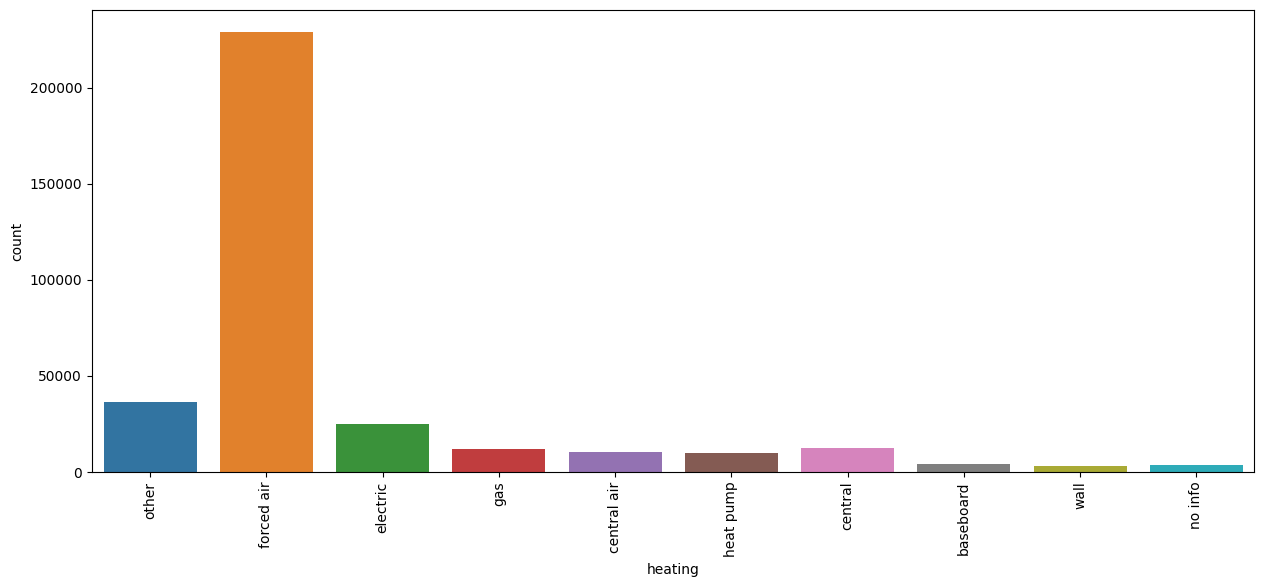

In [386]:
show_feature_info_hist(data_copy['heating'])

In [387]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345687 entries, 0 to 345689
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   propertyType  345687 non-null  object 
 1   baths         345687 non-null  object 
 2   homeFacts     345687 non-null  object 
 3   fireplace     102119 non-null  object 
 4   city          345678 non-null  object 
 5   schools       345687 non-null  object 
 6   sqft          321584 non-null  object 
 7   zipcode       345687 non-null  int64  
 8   beds          283289 non-null  object 
 9   state         345687 non-null  object 
 10  stories       345687 non-null  float64
 11  target        343227 non-null  object 
 12  sale_status   345687 non-null  object 
 13  private_pool  345687 non-null  int64  
 14  year_built    345687 non-null  int64  
 15  remodeling    345687 non-null  object 
 16  heating       345687 non-null  object 
dtypes: float64(1), int64(3), object(13)
memory usage

Извлечем следующий признак из столбца homeFacts - cooling(охлаждение).

In [388]:
data_copy['cooling'] = data_copy['homeFacts'].apply(lambda x: x['atAGlanceFacts'][3]['factValue'])

In [389]:
show_feature_info(data_copy['cooling'])

Количество пропусков: 3533

Описание: count      342154
unique       1445
top       Central
freq       157500
Name: cooling, dtype: object

Распределение:
Central                                                                157500
                                                                        90603
Central Air                                                             14384
No Data                                                                 10616
Has Cooling                                                              9730
                                                                        ...  
Central Gas, Propane, Zoned                                                 1
Other (See Remarks), Panel/Floor/Wall, Window Unit                          1
Multi Units, Zoned Cooling                                                  1
Central Air, g-Energy Star HVAC, Gas Hot Air/Furnace, Multizone A/C         1
Central A/C (Gas), Central Heat (Gas), Heat Pump                 

In [153]:
# data_copy.cooling.nunique()

In [154]:
# data_copy.cooling.isna().sum()

In [390]:
data_copy.cooling.value_counts()[:50]

Central                                                        157500
                                                                90603
Central Air                                                     14384
No Data                                                         10616
Has Cooling                                                      9730
None                                                             7095
Central Electric                                                 6151
Wall                                                             3955
Central Gas                                                      3573
Central Heating                                                  2807
Cooling System                                                   2699
Central A/C                                                      2051
Other                                                            1840
Central A/C (Electric), Central Heat (Gas)                       1646
Central A/C (Electri

В столбце имеется 1445 уникальных записи и 3533 пропусков. Преобразуем в читабельный вид. Для начала приведём всё к нижнему регистру.

In [391]:
data_copy['cooling'] = data_copy['cooling'].apply(lambda x: x.lower() if (x is not np.nan) & (x is not None) else x)
data_copy['cooling'] = data_copy['cooling'].apply(lambda x: np.nan if (x is None) | (x == 'none') | (x == '') else x)


Некоторые значения имеют различное написание, но одинаковый смысл. Приведём их к единообразию.

In [392]:
data_copy['cooling'] = data_copy['cooling'].replace('no data', np.nan).replace('none', np.nan)
data_copy['cooling'] = data_copy['cooling'].apply(lambda x: x if x is np.nan else ' '.join(x.split(' ')[:2]))
data_copy['cooling'] = data_copy['cooling'].apply(lambda x: x.replace(',', '') if type(x) is not float else x)
data_copy['cooling'] = data_copy['cooling'].replace('has cooling', 'cooling').replace('central a/c', 'central air')

По аналогии с признаком 'heating', выделим топ 10 популярных значений. остальные внесем в категорию other. Пропущенные значения заменим на самое распространенное.

In [393]:
# топ 10
cooling_list = list(data_copy['cooling'].value_counts()[:10].index)
data_copy['cooling'] = data_copy['cooling'].apply(lambda x: x if x is np.nan else x if x in cooling_list else 'other')
data_copy['cooling'] = data_copy['cooling'].fillna(data_copy['cooling'].describe().top)


Количество пропусков: 0

Описание: count      345687
unique         10
top       central
freq       269347
Name: cooling, dtype: object

Распределение:
central             269347
central air          24695
other                18130
cooling               9730
central electric      8385
central gas           4342
wall                  3955
central heating       3329
cooling system        2699
refrigeration         1075
Name: cooling, dtype: int64

Значения: ['central' 'central air' 'central gas' 'other' 'cooling'
 'central electric' 'central heating' 'wall' 'cooling system'
 'refrigeration']

Уникальные значения: 10



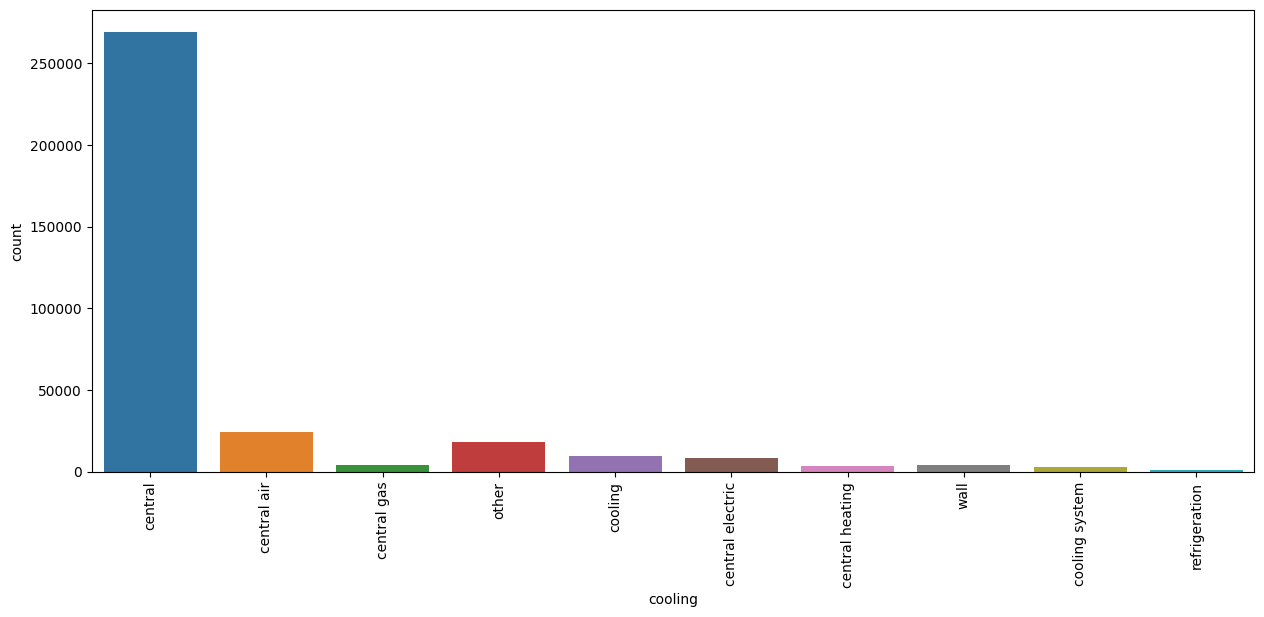

In [394]:
show_feature_info_hist(data_copy['cooling'])

Следующий признак, который мы можем извлечь из столбца homeFacts - это parking (парковка автомобиля).

In [395]:
data_copy['parking'] = data_copy['homeFacts'].apply(lambda x: x['atAGlanceFacts'][4]['factValue'])

In [396]:
show_feature_info(data_copy['parking'])

Количество пропусков: 3533

Описание: count     342154
unique      3319
top             
freq      142291
Name: parking, dtype: object

Распределение:
                                                                                                                                    142291
Attached Garage                                                                                                                      70121
2 spaces                                                                                                                             28063
1 space                                                                                                                              14252
No Data                                                                                                                              13334
                                                                                                                                     ...  
Dirt Driveway, 

In [162]:
# data_copy.parking.nunique()

In [163]:
# data_copy.parking.isna().sum()

In [397]:
data_copy.parking.value_counts().index.tolist()

['',
 'Attached Garage',
 '2 spaces',
 '1 space',
 'No Data',
 'Detached Garage',
 'Carport',
 '3 spaces',
 'Off Street',
 '4 spaces',
 '1',
 '2',
 'Carport, Attached Garage',
 'None',
 'Off street',
 'Attached Garage, Detached Garage',
 'On Street',
 '0',
 'Parking Desc',
 'Attached Garage, Carport',
 '6 spaces',
 'Detached Garage, Attached Garage',
 'Driveway',
 '5 spaces',
 '4',
 'On street',
 'Parking Type',
 'Off Street, Attached Garage',
 '3',
 'Off street parking',
 'Carport, Detached Garage',
 'Attached Garage, Garage - 2 Car',
 'Garage Type',
 'Parking YN',
 'Driveway, Garage Door Opener',
 'Garage - 2 Car',
 'Garage Door Opener',
 '888',
 'Attached Garage, Off Street',
 'Attached - FRONT',
 'Slab Parking Spaces',
 '8 spaces',
 'Off Street, On Street',
 'Detached Garage, Carport',
 '6',
 'Off Street, Detached Garage',
 'Garage-Attached',
 'Electric Door Opener',
 'Attached - SIDE',
 'Attached',
 'On Street, Off Street',
 '7 spaces',
 'Electric Door Opener, Slab Parking Spaces'

В столбце имеется 3319 уникальных записи и 3533 пропусков. Преобразуем информацию в признаке в читабельный вид.

In [398]:
data_copy['parking'] = data_copy['parking'].apply(lambda x: x.lower() if (x is not np.nan) & (x is not None) else x)
data_copy['parking'] = data_copy['parking'].apply(lambda x: np.nan if (x is None) | (x == '') else x)
data_copy['parking'] = data_copy['parking'].replace('no data', np.nan).replace('none', np.nan)
data_copy['parking'] = data_copy['parking'].apply(lambda x: x if x is np.nan else x.replace('+', '').replace(',', '').split(' ')[0])
data_copy['parking'] = data_copy['parking'].replace('drvwy', 'driveway').replace('garage', 'detached').replace(
    'garage-attached', 'detached').replace("attch'd", "attached")

data_copy.parking.value_counts()[:50]

attached             76069
2                    31559
1                    17407
detached             16359
carport              11360
off                   7406
3                     5295
4                     3524
on                    2242
parking               2237
driveway              1874
0                     1114
6                      953
electric               821
5                      818
assigned               735
8                      288
888                    251
slab                   229
7                      188
covered                176
concrete               143
10                     140
alley                  132
concr                  128
rv                     128
circular               118
aspht                  103
parkingtype            101
asphalt                 97
9                       92
boat                    91
basement                83
12                      76
open                    72
paved                   66
assigned/reserved       58
g

In [399]:
# Выделим топ 15 категорий, остальные обозначим 'other'
# Пропуски заменим на 'no info'
parking_list = list(data_copy['parking'].value_counts()[:15].index)

data_copy['parking'] = data_copy['parking'].apply(lambda x: x if x is np.nan else x if x in parking_list else 'other')
data_copy['parking'] = data_copy['parking'].fillna('no info')

In [400]:
data_copy.parking.value_counts()[:17]

no info     161484
attached     76069
2            31559
1            17407
detached     16359
carport      11360
off           7406
3             5295
other         5165
4             3524
on            2242
parking       2237
driveway      1874
0             1114
6              953
electric       821
5              818
Name: parking, dtype: int64

Количество пропусков: 0

Описание: count      345687
unique         17
top       no info
freq       161484
Name: parking, dtype: object

Распределение:
no info     161484
attached     76069
2            31559
1            17407
detached     16359
carport      11360
off           7406
3             5295
other         5165
4             3524
on            2242
parking       2237
driveway      1874
0             1114
6              953
electric       821
5              818
Name: parking, dtype: int64

Значения: ['no info' 'attached' 'detached' 'carport' '2' '4' 'off' '0' '1' '3'
 'other' 'on' 'parking' 'electric' '6' 'driveway' '5']

Уникальные значения: 17



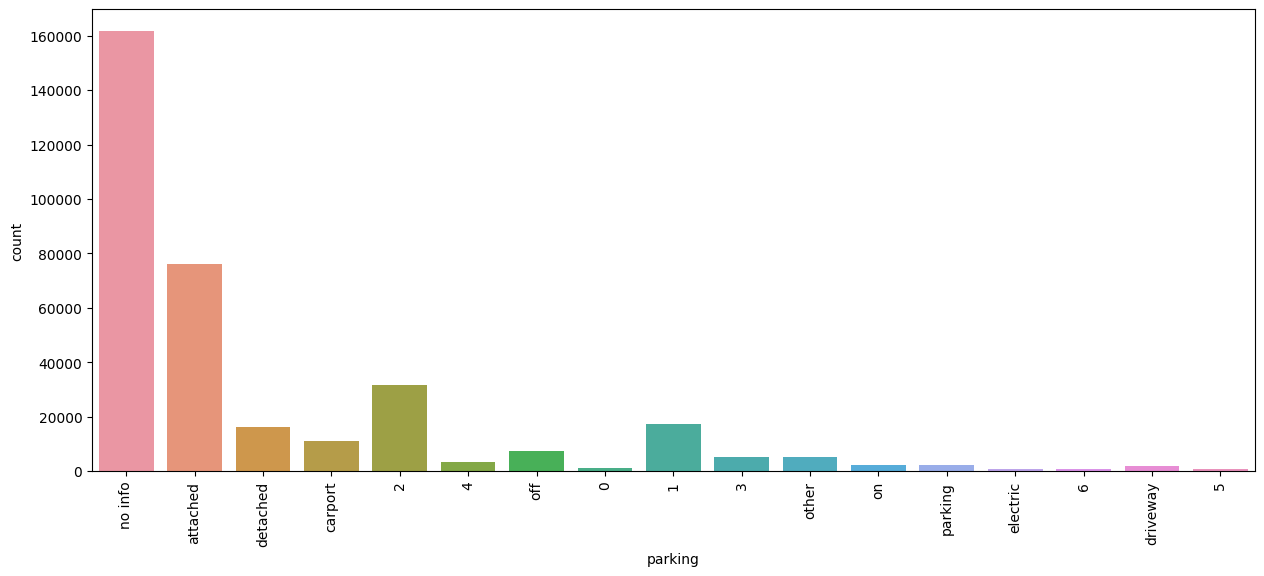

In [401]:
show_feature_info_hist(data_copy['parking'])

In [169]:
# data_copy.info()

Следующий признак, который заключен в столбце homeFacts - это lotsize (площадь земельного участка).

In [402]:
data_copy['lotsize'] = data_copy['homeFacts'].apply(lambda x: x['atAGlanceFacts'][5]['factValue'])

In [403]:
show_feature_info(data_copy['lotsize'])

Количество пропусков: 28219

Описание: count     317468
unique     34197
top             
freq       32476
Name: lotsize, dtype: object

Распределение:
                  32476
None              28219
—                 25242
No Data            5330
-- sqft lot        3819
                  ...  
3.93 acres lot        1
6,004 sqft lot        1
244807                1
7444 sqft             1
7,084 sqft lot        1
Name: lotsize, Length: 34198, dtype: int64

Значения: [None '5828 sqft' '8,626 sqft' ... '2,871 sqft' '8,019 sqft lot'
 '7,084 sqft lot']

Уникальные значения: 34198



In [172]:
# data_copy.lotsize.nunique()

In [173]:
# data_copy.lotsize.isna().sum()

In [174]:
# data_copy.lotsize.value_counts()

В признаке присутствует 34197 уникальных значения и 28220 пропусков. Также будем считать пропусками значения '—', 'No Data' и '-- sqft lot'. Видим, что значения записаны в разных единицах измерения - акры(acres) и квадратные фунты(sqft). Приведем все к единому виду, запятые заменим на точку. После обработки заменим пропущенные значения медианным.

In [404]:
# 1 acre = 43560 sqft

def change_acr(acr):
    """ Переводит акры в квадратные фунты

    Args:
        acr (str): значение в акрах

    Returns:
        float: значение в квадратных фунтах
    """
    sqft = 43560 * float(acr)
    return sqft

def lotsize_handler(df):
    """ Обработчик признака lotsize

    Args:
        df (Series): необработанный признак

    Returns:
        float/str: обработанный признак
    """
    
    # заменяем пропуски на No и приводим разделитель к общему виду
    df = df.replace('—', 'No').replace('No Data', 'No').replace('-- sqft lot', 'No').replace(',', '')
    
    if df != 'No':
        # приводим строку к нижнему регистру
        df = df.lower()
        # создаём лист со значениями 
        list_temp = df.split(' ')
        # если строка состоит из более чем одного значения, и второе значение 'acres' или 'acre', то переводим в кв фунты
        if (len(list_temp) > 1) and (df.split(' ')[1] == 'acres' or df.split(' ')[1] == 'acre'):
            df = change_acr(list_temp[0])
            return df
        else:
            df = float(list_temp[0])
            return df
    return df

In [405]:
# меняем пропущенные значения на No
data_copy['lotsize'] = data_copy['lotsize'].apply(lambda x: 'No' if (x is np.nan) | (x is None) | (x == '') else x)
# применяем функцию lotsize_handler
data_copy['lotsize'] = data_copy['lotsize'].apply(lotsize_handler)
# все No меняем на np.nan, отрицательные значения на 0
data_copy['lotsize'] = data_copy['lotsize'].apply(lambda x: np.nan if x == 'No' else 0 if x < 0 else x)
# заменяем пропуски на медианное значение
data_copy['lotsize'] = data_copy['lotsize'].fillna(data_copy['lotsize'].describe().median())


In [177]:
# data_copy.lotsize.isna().sum()

In [406]:
data_copy.lotsize.describe()

count    3.456870e+05
mean     8.430100e+04
std      5.438105e+06
min      0.000000e+00
25%      6.098000e+03
50%      1.084600e+04
75%      5.418095e+04
max      2.147484e+09
Name: lotsize, dtype: float64

Последний признак, который заключен в столбце homeFacts - это Price/sqft (цена 1 квадратного фута земли). Извлечем его.

In [407]:
data_copy['price/sqft'] = data_copy['homeFacts'].apply(lambda x: x['atAGlanceFacts'][6]['factValue'])
data_copy['price/sqft'].nunique()

6416

In [408]:
data_copy['price/sqft'].isna().sum()

31082

Считаю, что данный признак напрямую зависит от целевого признака 'target'. Поэтому удаляю его, чтобы не было утечки данных.

In [409]:
data_copy.drop('price/sqft', axis = 1, inplace = True)
# Удалим первоначальный признак 'homeFacts'
data_copy.drop('homeFacts', axis = 1, inplace = True)

In [410]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345687 entries, 0 to 345689
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   propertyType  345687 non-null  object 
 1   baths         345687 non-null  object 
 2   fireplace     102119 non-null  object 
 3   city          345678 non-null  object 
 4   schools       345687 non-null  object 
 5   sqft          321584 non-null  object 
 6   zipcode       345687 non-null  int64  
 7   beds          283289 non-null  object 
 8   state         345687 non-null  object 
 9   stories       345687 non-null  float64
 10  target        343227 non-null  object 
 11  sale_status   345687 non-null  object 
 12  private_pool  345687 non-null  int64  
 13  year_built    345687 non-null  int64  
 14  remodeling    345687 non-null  object 
 15  heating       345687 non-null  object 
 16  cooling       345687 non-null  object 
 17  parking       345687 non-null  object 
 18  lots

### Признак 'fireplace'

In [411]:
show_feature_info(data_copy['fireplace'])

Количество пропусков: 243568

Описание: count     102119
unique      1651
top          yes
freq       49392
Name: fireplace, dtype: object

Распределение:
NaN                                                                     243568
yes                                                                      49392
Yes                                                                      20856
1                                                                        14542
2                                                                         2432
                                                                         ...  
Gas, Wood Burning, Two, Propane Logs Convey                                  1
Free-standing, Insert, Wood                                                  1
Wood Burning, Attached Fireplace Doors/Screen, Electric, Gas Starter         1
One, Living Room                                                             1
Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets

In [184]:
# data_copy.fireplace.nunique()

In [185]:
# data_copy.fireplace.isna().sum()

In [412]:
data_copy.fireplace.value_counts()[:50]

yes                                                                         49392
Yes                                                                         20856
1                                                                           14542
2                                                                            2432
Not Applicable                                                               1993
Fireplace                                                                     847
3                                                                             564
Living Room                                                                   433
LOCATION                                                                      399
Wood Burning                                                                  311
Gas/Gas Logs                                                                  300
Fireplace YN                                                                  287
Special Features

В столбце содержится 1651 уникальных значений и 243566 пропусков. Логично предположить, что здесь пропуск означает отсутствие камина. Поэтому целесообразно заполнить все пропуски значением 'no'.

In [413]:
data_copy.fireplace = data_copy.fireplace.fillna('no')

Некоторые значения имеют различное написание, но одинаковый смысл. Приведём их к единообразию. Для начала приведём всё к нижнему регистру.

In [414]:
data_copy['fireplace'] = data_copy['fireplace'].apply(lambda x: str(x).lower())
data_copy.fireplace.value_counts()[:50]

no                                                                          243833
yes                                                                          70248
1                                                                            14542
2                                                                             2432
not applicable                                                                1993
fireplace                                                                      847
3                                                                              564
living room                                                                    433
location                                                                       399
wood burning                                                                   311
gas/gas logs                                                                   300
fireplace yn                                                                   287
spec

In [415]:
# Заменим значение '0' на 'no'
data_copy['fireplace'] = data_copy['fireplace'].apply(lambda x: 'no' if x=='0' else x)

In [416]:
# Проведем бинарное кодирование столбца: заменим все значения, которые не равны 'no' на 'yes'
data_copy['fireplace'] = data_copy['fireplace'].apply(lambda x: 'yes' if x!='no' else x)

Количество пропусков: 0

Описание: count     345687
unique         2
top           no
freq      244104
Name: fireplace, dtype: object

Распределение:
no     244104
yes    101583
Name: fireplace, dtype: int64

Значения: ['yes' 'no']

Уникальные значения: 2



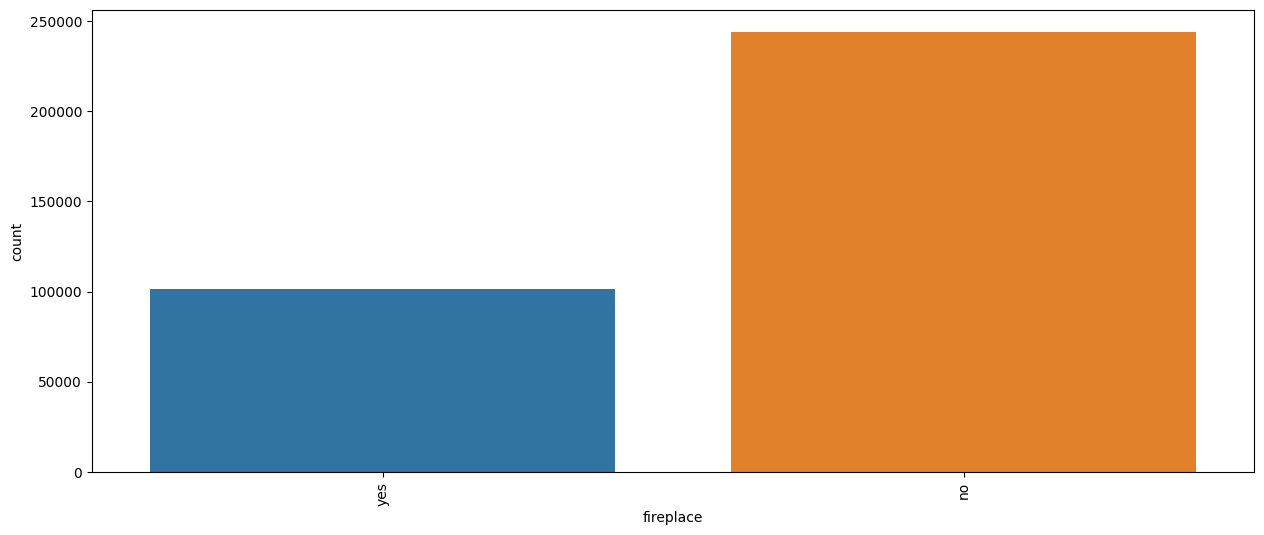

In [417]:
show_feature_info_hist(data_copy['fireplace'])

In [418]:
# на это этапе сделаю еще одну копию
data_c = data_copy.copy()
data_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345687 entries, 0 to 345689
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   propertyType  345687 non-null  object 
 1   baths         345687 non-null  object 
 2   fireplace     345687 non-null  object 
 3   city          345678 non-null  object 
 4   schools       345687 non-null  object 
 5   sqft          321584 non-null  object 
 6   zipcode       345687 non-null  int64  
 7   beds          283289 non-null  object 
 8   state         345687 non-null  object 
 9   stories       345687 non-null  float64
 10  target        343227 non-null  object 
 11  sale_status   345687 non-null  object 
 12  private_pool  345687 non-null  int64  
 13  year_built    345687 non-null  int64  
 14  remodeling    345687 non-null  object 
 15  heating       345687 non-null  object 
 16  cooling       345687 non-null  object 
 17  parking       345687 non-null  object 
 18  lots

In [419]:
# обратная копия
data_copy = data_c.copy()

### Признак 'city'

In [420]:
show_feature_info(data_copy['city'])

Количество пропусков: 9

Описание: count      345678
unique       1912
top       Houston
freq        23333
Name: city, dtype: object

Распределение:
Houston         23333
Miami           15391
San Antonio     15114
Jacksonville     9595
Dallas           8544
                ...  
Suwannee            1
FORT COLLINS        1
Kagel Canyon        1
New Albany          1
Blue Springs        1
Name: city, Length: 1913, dtype: int64

Значения: ['Southern Pines' 'Spokane Valley' 'Los Angeles' ... 'Dimondale'
 'HAINES CITY' 'Blue Springs']

Уникальные значения: 1913



In [195]:
# data_copy.city.nunique()

In [196]:
# data_copy.city.isna().sum()

In [421]:
data_copy.city.value_counts().index.tolist()

['Houston',
 'Miami',
 'San Antonio',
 'Jacksonville',
 'Dallas',
 'Brooklyn',
 'New York',
 'Chicago',
 'Charlotte',
 'Las Vegas',
 'Fort Worth',
 'Fort Lauderdale',
 'Orlando',
 'Austin',
 'Tampa',
 'Washington',
 'Nashville',
 'Cleveland',
 'Philadelphia',
 'Seattle',
 'Los Angeles',
 'Atlanta',
 'Detroit',
 'Kissimmee',
 'Miami Beach',
 'Saint Petersburg',
 'Ocala',
 'Memphis',
 'Raleigh',
 'Indianapolis',
 'Denver',
 'Portland',
 'El Paso',
 'ORLANDO',
 'Durham',
 'Chattanooga',
 'Palm Coast',
 'TAMPA',
 'San Diego',
 'Lakewood',
 'Reno',
 'Cincinnati',
 'Cape Coral',
 'Flushing',
 'Hialeah',
 'PORT CHARLOTTE',
 'Sacramento',
 'Glendale',
 'Hollywood',
 'Fresno',
 'Bronx',
 'Doral',
 'Staten Island',
 'Jamaica',
 'Coral Gables',
 'College Station',
 'Knoxville',
 'Boston',
 'Irvine',
 'Vancouver',
 'ST PETERSBURG',
 'Clarksville',
 'Lauderhill',
 'San Francisco',
 'Davie',
 'PUNTA GORDA',
 'West Palm Beach',
 'Tamarac',
 'Aventura',
 'Sunrise',
 'Wilmington',
 'Richmond',
 'Bonita

Столбец имеет 1912 уникальных значений и 9 пропусков. После первичного анализа признака заметил, что есть записи как с заглавной так и строчной буквы. 

In [422]:
# Приведем все к нижнему регистру
data_copy['city'] = data_copy['city'].apply(lambda x: str(x).lower())
data_copy.city.value_counts().index.tolist()

['houston',
 'miami',
 'san antonio',
 'jacksonville',
 'dallas',
 'brooklyn',
 'new york',
 'orlando',
 'chicago',
 'tampa',
 'charlotte',
 'las vegas',
 'fort worth',
 'fort lauderdale',
 'austin',
 'washington',
 'nashville',
 'cleveland',
 'philadelphia',
 'seattle',
 'los angeles',
 'kissimmee',
 'atlanta',
 'detroit',
 'miami beach',
 'denver',
 'saint petersburg',
 'ocala',
 'memphis',
 'raleigh',
 'indianapolis',
 'port charlotte',
 'portland',
 'el paso',
 'durham',
 'chattanooga',
 'palm coast',
 'san diego',
 'lakewood',
 'punta gorda',
 'reno',
 'cincinnati',
 'cape coral',
 'flushing',
 'hialeah',
 'sacramento',
 'glendale',
 'hollywood',
 'fresno',
 'bronx',
 'doral',
 'st petersburg',
 'staten island',
 'jamaica',
 'coral gables',
 'college station',
 'knoxville',
 'boston',
 'irvine',
 'vancouver',
 'clarksville',
 'lauderhill',
 'san francisco',
 'davie',
 'west palm beach',
 'tamarac',
 'aventura',
 'mckinney',
 'sunrise',
 'wilmington',
 'richmond',
 'bonita springs'

In [423]:
data_copy['city'].str.title().nunique()

1799

Также есть разные записи одного и того же города, например:  'allentown' и 'allentown city'; 'anderson township' и 'anderson twp'; 'asheville' и 'asheville city'; 'atlaanta' и 'atlanta'; 'saint petersburg' и 'st petersburg'; 'panama city beach' и 'panama city' и т.д.

In [424]:
list_city = data_copy['city'].sort_values().unique().tolist()
list_city[0:1000]

[' ',
 '--',
 'abilene',
 'abingdon',
 'accokeek',
 'adams',
 'addison',
 'adel',
 'adelphi',
 'advance',
 'akron',
 'alamo heights',
 'albany',
 'albion',
 'alburgh',
 'alden',
 'aledo',
 'alexandria',
 'algona',
 'alhambra',
 'allen',
 'allentown',
 'allentown city',
 'allston',
 'alta loma',
 'altadena',
 'altamonte springs',
 'alto',
 'alvin',
 'alviso',
 'alys beach',
 'amanda',
 'amarillo',
 'american canyon',
 'amherst',
 'anaheim',
 'anderson',
 'anderson island',
 'anderson township',
 'anderson twp',
 'angola',
 'ann arbor',
 'annandale',
 'antelope',
 'anthony',
 'antioch',
 'apex',
 'apison',
 'apopka',
 'arcadia',
 'archdale',
 'arden',
 'argyle',
 'arkwright',
 'arleta',
 'arlington',
 'arrington',
 'arvada',
 'arverne',
 'asheville',
 'asheville city',
 'ashland city',
 'ashville',
 'astoria',
 'athens',
 'atlaanta',
 'atlanta',
 'atlantic beach',
 'auburn',
 'augusta',
 'aurora',
 'austin',
 'ave',
 'aventura',
 'avondale',
 'babcock ranch',
 'bahama',
 'bainbridge is',

In [201]:
# list_city[1001:1799]

Кроме как обрабатывать вручную каждый город из списка, не вижу другого выхода. Это очень трудоемкий процесс, поэтому не буду этого делать!!! 

Поэтому принимаю решение, выделить топ город, которые описывают 80% примеров. Остальные занесу в категорию 'other'

In [425]:
cities_with_freqs = list(data_copy.city.value_counts())
top_cities_count = int(np.percentile(cities_with_freqs, 80))
top_cities_count

99

In [426]:
top_cities_count = list(data_copy['city'].value_counts()[:99].index)

data_copy['city'] = data_copy['city'].apply(lambda x: x if x is np.nan else x if x in top_cities_count else 'other')
data_copy['city'] = data_copy['city'].fillna('other')

In [427]:
data_copy.city.value_counts().index.tolist()

['other',
 'houston',
 'miami',
 'san antonio',
 'jacksonville',
 'dallas',
 'brooklyn',
 'new york',
 'orlando',
 'chicago',
 'tampa',
 'charlotte',
 'las vegas',
 'fort worth',
 'fort lauderdale',
 'austin',
 'washington',
 'nashville',
 'cleveland',
 'philadelphia',
 'seattle',
 'los angeles',
 'kissimmee',
 'atlanta',
 'detroit',
 'miami beach',
 'denver',
 'saint petersburg',
 'ocala',
 'memphis',
 'raleigh',
 'indianapolis',
 'port charlotte',
 'portland',
 'el paso',
 'durham',
 'chattanooga',
 'palm coast',
 'san diego',
 'lakewood',
 'punta gorda',
 'reno',
 'cincinnati',
 'cape coral',
 'flushing',
 'hialeah',
 'sacramento',
 'glendale',
 'hollywood',
 'fresno',
 'bronx',
 'doral',
 'st petersburg',
 'staten island',
 'jamaica',
 'coral gables',
 'college station',
 'knoxville',
 'boston',
 'irvine',
 'vancouver',
 'clarksville',
 'lauderhill',
 'san francisco',
 'davie',
 'west palm beach',
 'tamarac',
 'aventura',
 'mckinney',
 'sunrise',
 'wilmington',
 'richmond',
 'bonit

Признак категориальный. Если категориальных признаков будут слишком много, то придется уменьшить число категории признака 'city' или удалить его.

Количество пропусков: 0

Описание: count     345687
unique       100
top        other
freq       89040
Name: city, dtype: object

Распределение:
other            89040
houston          23333
miami            15395
san antonio      15114
jacksonville      9612
                 ...  
north miami        644
peoria             633
midland            615
thornton           615
pompano beach      614
Name: city, Length: 100, dtype: int64

Значения: ['other' 'los angeles' 'dallas' 'philadelphia' 'poinciana' 'memphis'
 'houston' 'flushing' 'brooklyn' 'fort lauderdale' 'new york'
 'miami beach' 'spring' 'washington' 'miami' 'davie' 'tampa'
 'jacksonville' 'charlotte' 'fresno' 'weston' 'las vegas' 'fort worth'
 'portland' 'durham' 'plantation' 'san antonio' 'cleveland' 'chicago'
 'lakewood' 'seattle' 'port charlotte' 'kissimmee' 'boston' 'spokane'
 'port saint lucie' 'panama city beach' 'orlando' 'college station'
 'palm coast' 'lauderhill' 'coral gables' 'mckinney' 'san jose' 'austin'
 'nashvil

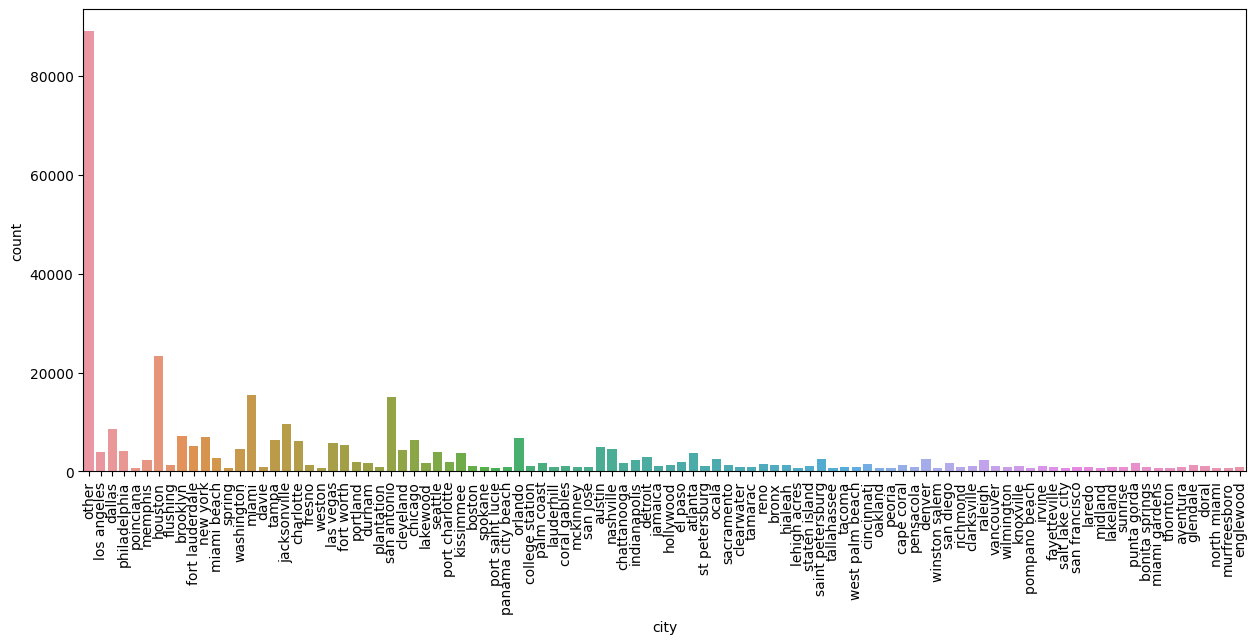

In [428]:
show_feature_info_hist(data_copy['city'])

### Признак 'schools'

In [429]:
show_feature_info(data_copy['schools'])

Количество пропусков: 0

Описание: count                                                345687
unique                                               271181
top       [{'rating': [], 'data': {'Distance': [], 'Grad...
freq                                                   3094
Name: schools, dtype: object

Распределение:
[{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}]                                                                                                                                                                                                                                                                                                                                                                                                                                            3094
[{'rating': ['4/10', '5/10', '6/10'], 'data': {'Distance': ['39.69mi', '39.69mi', '39.69mi'], 'Grades': ['9-12', '6-8', 'PK-5']}, 'name': ['Fort Hancock High School', 'Fort Hancoc

Здесь содержатся данные о школах. Данные имеют формат json с вложенными словарями и списками в списках, такие как: rating - рейтинги школ, Distance - расстояния до школ, Grades - возрастной уровень школ и name - названия школ.

Название школы и возрастной уровень считаю не особо важным, поэтому не будем рассматривать их.

Извлечём данные.

In [430]:
data_copy['rating'] = data_copy['schools'].apply(lambda x: ast.literal_eval(x)[0]['rating'])
data_copy['distance'] = data_copy['schools'].apply(lambda x: ast.literal_eval(x)[0]['data']['Distance'])
# удалим признак 'schools'
data_copy = data_copy.drop(['schools'], axis=1)

In [431]:
# проверим пропуски
data_copy['rating'].isna().sum()

0

Посмотрим на структуру данных.

In [432]:
for i in range(10):
    print(data_copy['rating'].loc[i])

['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']
['4/10', 'None/10', '4/10']
['8/10', '4/10', '8/10']
['9/10', '9/10', '10/10', '9/10']
[]
['3', '3', '1', 'NR']
['4', '2', '2']
['2', '2', '4', '7', '4', 'NR']
['4/10', '3/10', '2/10']
['2/10', '8/10', '10/10']


In [433]:
def rating_handler(df):
    """ Обработчик признака rating

    Args:
        df (Series): необработанный признак

    Returns:
        float/np.nan: обработанный признак
    """
    temp_list = []
    rating_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    
    if df == []:
        return np.nan
    else:
        for i in df:
            i = i.split('/')[0]
            if i in rating_list:
                temp_list.append(float(i))
        rating_mean = round(np.mean(temp_list), 2)
        return rating_mean   

In [434]:
# создадим новый признак 'mean_school_rating' и применим функцию rating_handler
data_copy['mean_school_rating'] = data_copy['rating'].apply(rating_handler)
# заменяем пропуски на среднее значение
data_copy['mean_school_rating'] = data_copy['mean_school_rating'].fillna(round(data_copy['mean_school_rating'].mean(), 2))
# удалим признак 'rating'
data_copy = data_copy.drop(['rating'], axis=1)                                                           

c:\Users\sphex\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [435]:
data_copy['mean_school_rating'].value_counts()

6.00    21409
4.00    18464
5.00    18017
3.00    16699
6.33    15080
        ...  
1.44        1
1.90        1
1.20        1
5.88        1
4.54        1
Name: mean_school_rating, Length: 228, dtype: int64

In [ ]:
# Посмотрим на гистограмму распределения
plt.figure(figsize = (14,7))
data_copy['mean_school_rating'].hist(bins=20)

Признак 'distance' представляет собой список из расстояний до школ. Создадим 2 новых признака 'mean_distance_to_school' - среднее расстояние до школы и количество школ на районе - 'schools_count'.

In [437]:
# проверим пропуски
data_copy['distance'].isnull().sum()

0

Посмотрим на структуру данных.

In [438]:
for i in range(10):
    print(data_copy['distance'].loc[i])

['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi']
['1.65mi', '1.32mi', '1.01mi']
['1.19mi', '2.06mi', '2.63mi']
['1.05mi', '0.1mi', '1.05mi', '0.81mi']
[]
['0.8 mi', '8.3 mi', '4.2 mi', '2.0 mi']
['0.7 mi', '0.4 mi', '2.2 mi']
['5.6 mi', '5.6 mi', '6.8 mi', '6.5 mi', '6.8 mi', '6.8 mi']
['0.7 mi', '0.6 mi', '1.9 mi']
['0.3mi', '1.88mi', '2.37mi']


In [439]:
def distance_handler(df):
    """ Обработчик признака distance

    Args:
        df (Serise): необработанный признак

    Returns:
        list: обработанные признаки - средняя дистанция и количество школ
    """
    temp_list = []
    
    for i in df:
        i = i.split('mi')[0]
        temp_list.append(float(i))
    dist_mean = round(np.mean(temp_list), 2)
    schools_count = len(temp_list)
    return [dist_mean, schools_count]

In [440]:
# создаем новый признак 'mean_distance_to_school' и применяем функцию distance_handler
data_copy['mean_distance_to_school'] = data_copy['distance'].apply(lambda x: distance_handler(x)[0])
# создаем новый признак 'schools_count' и также применяем функцию distance_handler
data_copy['schools_count'] = data_copy['distance'].apply(lambda x: distance_handler(x)[1])
# заменим пропуски на медианное значение
data_copy['schools_count'] = data_copy['schools_count'].apply(lambda x: data_copy['schools_count'].median() if x==0 else x)
# заменим пропуски на среднее значение
data_copy['mean_distance_to_school'] = data_copy['mean_distance_to_school'].fillna(round(data_copy['mean_distance_to_school'].mean(), 2))

c:\Users\sphex\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\sphex\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [441]:
data_copy['mean_distance_to_school'].value_counts()

2.78      3489
0.90      3243
1.00      3141
1.10      3129
1.20      2969
          ... 
25.70        1
40.30        1
463.48       1
25.10        1
25.04        1
Name: mean_distance_to_school, Length: 1956, dtype: int64

In [442]:
data_copy['schools_count'].value_counts()

3.0     197813
8.0      34487
2.0      33750
5.0      28287
4.0      21017
6.0       9125
1.0       7467
7.0       5351
24.0      1716
13.0      1031
63.0       761
10.0       751
12.0       719
11.0       632
9.0        535
15.0       506
14.0       404
22.0       398
65.0       346
49.0       257
16.0       121
61.0       110
21.0        96
17.0         5
19.0         2
Name: schools_count, dtype: int64

In [443]:
# удалим признак 'distance'
data_copy = data_copy.drop(['distance'], axis=1)

In [444]:
# на это этапе сделаю еще одну копию
data_c = data_copy.copy()
data_c.tail()

,propertyType,baths,fireplace,city,sqft,zipcode,beds,state,stories,target,...,private_pool,year_built,remodeling,heating,cooling,parking,lotsize,mean_school_rating,mean_distance_to_school,schools_count
345685,single-family,6,no,miami,"4,017",33180,5,FL,1.0,"$1,249,000",...,1,1990,yes,other,central,2,8500.000000,7.50,16.60,2.0
345686,condo,3,no,chicago,"2,000 sqft",60657,3 Beds,IL,9.0,"$674,999",...,0,1924,no,central,central,no info,54180.951381,4.33,4.14,3.0
345687,single-family,3,no,jamaica,"1,152 sqft",11434,3 Beds,NY,2.0,"$528,000",...,0,1950,yes,other,central,2,1600.000000,4.50,0.60,2.0
345688,single-family,2,no,houston,NaN,77028,"8,479 sqft",TX,1.0,"$34,500",...,0,1985,no,no info,central,no info,54180.951381,5.19,1.23,3.0
345689,single-family,2,yes,san antonio,"1,462",78218,3,TX,1.0,"$204,900",...,0,2019,no,electric,central,no info,6969.000000,4.00,1.83,3.0


In [445]:
data_copy = data_c.copy()
data_copy.tail()

,propertyType,baths,fireplace,city,sqft,zipcode,beds,state,stories,target,...,private_pool,year_built,remodeling,heating,cooling,parking,lotsize,mean_school_rating,mean_distance_to_school,schools_count
345685,single-family,6,no,miami,"4,017",33180,5,FL,1.0,"$1,249,000",...,1,1990,yes,other,central,2,8500.000000,7.50,16.60,2.0
345686,condo,3,no,chicago,"2,000 sqft",60657,3 Beds,IL,9.0,"$674,999",...,0,1924,no,central,central,no info,54180.951381,4.33,4.14,3.0
345687,single-family,3,no,jamaica,"1,152 sqft",11434,3 Beds,NY,2.0,"$528,000",...,0,1950,yes,other,central,2,1600.000000,4.50,0.60,2.0
345688,single-family,2,no,houston,NaN,77028,"8,479 sqft",TX,1.0,"$34,500",...,0,1985,no,no info,central,no info,54180.951381,5.19,1.23,3.0
345689,single-family,2,yes,san antonio,"1,462",78218,3,TX,1.0,"$204,900",...,0,2019,no,electric,central,no info,6969.000000,4.00,1.83,3.0


### Признак 'sqft'

In [446]:
show_feature_info(data_copy['sqft'])

Количество пропусков: 24103

Описание: count     321584
unique     24931
top            0
freq         948
Name: sqft, dtype: object

Распределение:
NaN                                        24103
0                                            948
1,200 sqft                                   814
1,000 sqft                                   639
1,100 sqft                                   566
                                           ...  
24,093 sqft                                    1
153,693 sqft                                   1
4,826 sqft                                     1
7,094 sqft                                     1
Total interior livable area: 4,615 sqft        1
Name: sqft, Length: 24932, dtype: int64

Значения: ['2900' '1,947 sqft' '3,000 sqft' ... '4371' '13,870 sqft'
 'Total interior livable area: 4,615 sqft']

Уникальные значения: 24932



In [224]:
# data_copy.sqft.nunique()

In [225]:
# data_copy.sqft.isna().sum()

В столбце 24931 уникальных значений и 24103 пропуска. Стоит отметить что признак имеет разный формат записи: '1,200 sqft', '--', '-- sqft', а также несколько значенией в виде, например: 'Total interior livable area: 4,615 sqft'. Сначала заполним все пропуски значением 0, затем преобразуем в читабельный вид, избавившись от букв и лишних символов. После преобразуем признак в числовой и заполним все 0 медианойна медиану.

In [447]:
# заполним все пропуски 0
data_copy['sqft'] = data_copy['sqft'].fillna('0')

In [448]:
# приводим в читабельный вид
def sqft_handler(x):
    x = x.replace('--', '0')
    x = re.sub('[^\-0-9]', '', x)
    if x== '610-840':
        x = '840'
    return x

In [449]:
data_copy['sqft'] = data_copy['sqft'].apply(sqft_handler)

In [450]:
# переводим в числовой
data_copy['sqft'] = data_copy['sqft'].apply(lambda x: int(x))

In [451]:
data_copy['sqft'].value_counts()

0         25871
1200       1401
1000       1012
1500        999
1800        981
          ...  
21420         1
256750        1
10438         1
100000        1
13870         1
Name: sqft, Length: 9497, dtype: int64

In [452]:
data_copy['sqft'] = data_copy['sqft'].apply(lambda x: data_copy['sqft'].median() if x==0 else x)

In [453]:
data_copy['sqft'].describe()

count    3.456870e+05
mean     6.314897e+03
std      1.560806e+06
min      1.000000e+00
25%      1.343000e+03
50%      1.748000e+03
75%      2.535000e+03
max      7.959794e+08
Name: sqft, dtype: float64

Признак имеет большой разброс. Стандартное отклонение 1560806 квадратных футов. Минимальное значение 1, а максимальное почти 795979400 квадратных футов. При этом медиана равна 1748.

In [233]:
# data_copy[data_copy.sqft==1]

In [454]:
# посмотрим на значения свыше 1000000 кв. футов
data_copy[data_copy.sqft > 1.0e6]

,propertyType,baths,fireplace,city,sqft,zipcode,beds,state,stories,target,...,private_pool,year_built,remodeling,heating,cooling,parking,lotsize,mean_school_rating,mean_distance_to_school,schools_count
57535,single-family,2,yes,cincinnati,795979430.0,45225,2 Beds,OH,1.0,"$27,500",...,0,1901,no,forced air,wall,attached,2874.0,2.45,3.98,11.0
158862,single-family,2,no,other,1916640.0,78073,NaN,TX,1.0,"$660,000",...,0,1985,no,forced air,central,no info,1916640.0,4.00,2.03,1.0
232626,single-family,other,no,san antonio,2585006.0,78255,Baths,TX,1.0,"138,000",...,0,1985,no,forced air,central,no info,25700.4,7.67,6.83,3.0
325219,single-family,other,no,san antonio,2807917.0,78255,Baths,TX,1.0,"114,900",...,0,1985,no,forced air,central,no info,27878.4,7.67,6.87,3.0
345091,multi-family,2,no,glendale,456602479.0,42740,NaN,KY,1.0,"$198,000",...,0,2012,no,other,central air,no info,456509.0,6.33,4.98,6.0


Принимаю решение удалить их.

In [455]:
data_copy = data_copy.drop(index=[57535, 158862, 232626, 325219, 345091])

In [456]:
data_copy['sqft'].describe()

count    345682.000000
mean       2670.333335
std       12586.391087
min           1.000000
25%        1343.000000
50%        1748.000000
75%        2535.000000
max      967300.000000
Name: sqft, dtype: float64

In [459]:

data_copy[data_copy.sqft==967300]

,propertyType,baths,fireplace,city,sqft,zipcode,beds,state,stories,target,...,private_pool,year_built,remodeling,heating,cooling,parking,lotsize,mean_school_rating,mean_distance_to_school,schools_count
68988,cooperative,2,no,new york,967300.0,10022,NaN,NY,38.0,"$825,000",...,1,1969,no,gas,central,1,46609.200000,7.86,2.15,7.0
131834,cooperative,2,no,new york,967300.0,10022,2,NY,38.0,NaN,...,1,1968,no,forced air,central,no info,54180.951381,7.00,1.60,3.0


In [460]:
data_copy = data_copy.drop(index=[68988, 131834])

С минимальным значение пока повременим, но будем иметь ввиду в дальнейшем...

## Признак 'beds'

In [461]:
show_feature_info(data_copy['beds'])

Количество пропусков: 62395

Описание: count     283285
unique      1180
top       3 Beds
freq       52432
Name: beds, dtype: object

Распределение:
NaN            62395
3 Beds         52432
4 Beds         34981
3              31402
2 Beds         25701
               ...  
7,841 sqft         1
8,023 sqft         1
10,193 sqft        1
8.93 acres         1
8,479 sqft         1
Name: beds, Length: 1181, dtype: int64

Значения: ['4' '3 Beds' '5 Beds' ... '9,565 sqft' '1.74 acres' '8,479 sqft']

Уникальные значения: 1181



In [238]:
# data_copy.beds.isna().sum()

In [239]:
# data_copy.beds.value_counts()[:50]

Данный признак является слишком грязным, к тому же здесь очень много пропусков. Принимаем решение не использовать его и удалить.

In [462]:
data_copy.drop(['beds'], axis=1, inplace=True)


### Признак 'state'

In [463]:
show_feature_info(data_copy['state'])

Количество пропусков: 0

Описание: count     345680
unique        37
top           FL
freq      102902
Name: state, dtype: object

Распределение:
FL    102902
TX     78493
NY     24022
CA     22366
NC     18976
TN     15953
WA     12626
OH     11660
IL      8296
NV      7722
CO      6232
GA      5933
PA      4927
MI      4764
DC      4599
AZ      3236
IN      2885
OR      2563
MA      1499
UT      1226
MD      1082
MO       866
VT       722
VA       693
WI       438
NJ       428
IA       212
ME       190
KY        75
OK        30
SC        27
MS        26
DE         5
MT         3
Fl         1
BA         1
OT         1
Name: state, dtype: int64

Значения: ['NC' 'WA' 'CA' 'TX' 'PA' 'FL' 'TN' 'IA' 'NY' 'OR' 'DC' 'NV' 'GA' 'IL'
 'NJ' 'MA' 'IN' 'OH' 'UT' 'MI' 'VT' 'AZ' 'MD' 'CO' 'VA' 'KY' 'MO' 'WI'
 'ME' 'MS' 'OK' 'SC' 'MT' 'DE' 'Fl' 'BA' 'OT']

Уникальные значения: 37



In [242]:
# data_copy.state.nunique()

In [243]:
# data_copy.state.isna().sum()

В столбце 37 уникальных значений и 0 пропусков.

In [464]:
# приведем значения к верхнему регистру
data_copy['state'] = data_copy['state'].apply(lambda x: x.upper())
data_copy['state'].unique()

array(['NC', 'WA', 'CA', 'TX', 'PA', 'FL', 'TN', 'IA', 'NY', 'OR', 'DC',
       'NV', 'GA', 'IL', 'NJ', 'MA', 'IN', 'OH', 'UT', 'MI', 'VT', 'AZ',
       'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT',
       'DE', 'BA', 'OT'], dtype=object)

In [465]:
data_copy.state.value_counts()

FL    102903
TX     78493
NY     24022
CA     22366
NC     18976
TN     15953
WA     12626
OH     11660
IL      8296
NV      7722
CO      6232
GA      5933
PA      4927
MI      4764
DC      4599
AZ      3236
IN      2885
OR      2563
MA      1499
UT      1226
MD      1082
MO       866
VT       722
VA       693
WI       438
NJ       428
IA       212
ME       190
KY        75
OK        30
SC        27
MS        26
DE         5
MT         3
BA         1
OT         1
Name: state, dtype: int64

Выделим топ 15 штатов, остальные отправим в категорию 'other'

In [466]:
data_copy['state'].unique()[:15]

array(['NC', 'WA', 'CA', 'TX', 'PA', 'FL', 'TN', 'IA', 'NY', 'OR', 'DC',
       'NV', 'GA', 'IL', 'NJ'], dtype=object)

In [467]:
# С целью уменьшения числа категорий, выберем топ 15 штатов
top_state = data_copy['state'].value_counts()[:15].index
data_copy['state'] = data_copy['state'].apply(lambda x: x 
                                            if x in top_state else 'other')

In [468]:
data_copy['state'].value_counts()

FL       102903
TX        78493
NY        24022
CA        22366
NC        18976
other     16208
TN        15953
WA        12626
OH        11660
IL         8296
NV         7722
CO         6232
GA         5933
PA         4927
MI         4764
DC         4599
Name: state, dtype: int64

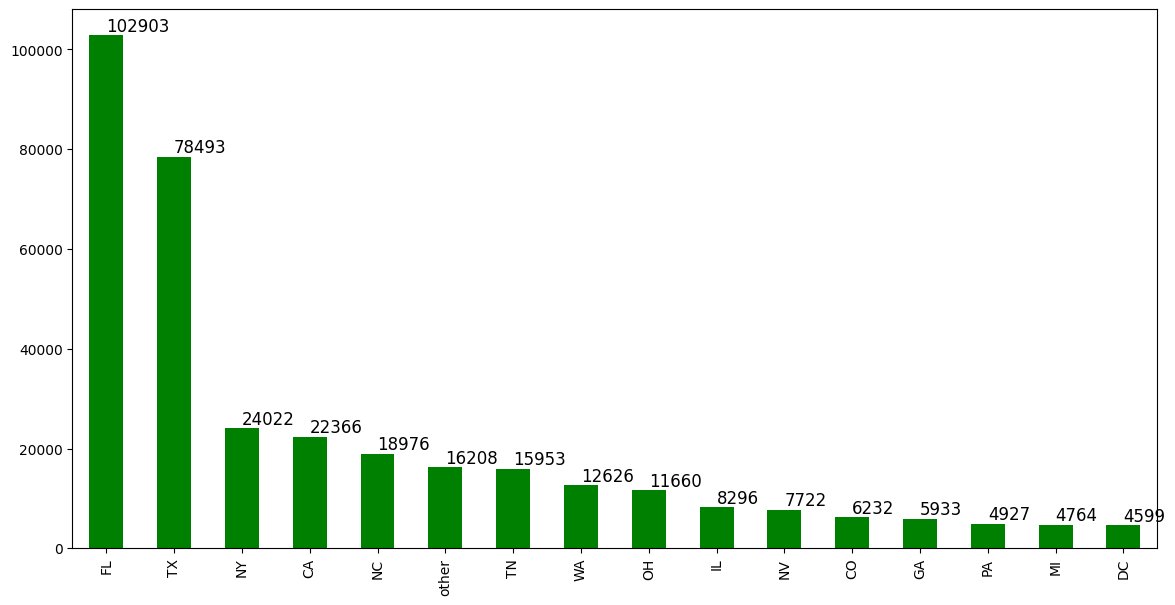

In [469]:
show_plot(data_copy['state'])

In [470]:
data_c = data_copy.copy()

In [558]:
data_copy = data_c.copy()

### Целевой признак 'target'

In [559]:
show_feature_info(data_copy['target'])

Количество пропусков: 2459

Описание: count       343221
unique       42791
top       $225,000
freq          1286
Name: target, dtype: object

Распределение:
NaN           2459
$225,000      1286
$275,000      1217
$299,900      1195
$249,900      1188
              ... 
$441,275         1
$1,799,219       1
$112,400         1
$497,331         1
$171,306         1
Name: target, Length: 42792, dtype: int64

Значения: ['$418,000' '$310,000' '$2,895,000' ... '$815,881' '342,969' '$171,306']

Уникальные значения: 42792



In [272]:
# data.target.nunique()

In [273]:
# data.target.isna().sum()


Столбец имеет 42791 уникальных значений и 2459 пропусков.

Пропусков не так много, поэтому принимаю решение удалить их.

In [560]:
data_copy.drop(data_copy[data_copy.target.isna()].index, inplace=True)
data_copy = data_copy.reset_index(drop=True)

In [561]:
# удалим знак $ и запятые
def make_target(x):
    x = re.sub('[^0-9]', '',x)
    x = int(x)
    return x

data_copy.target = data_copy.target.apply(make_target)

In [562]:
data_copy['target'].describe()

count    3.432210e+05
mean     6.747532e+05
std      1.874100e+06
min      1.000000e+00
25%      2.099000e+05
50%      3.390000e+05
75%      5.999000e+05
max      1.950000e+08
Name: target, dtype: float64

Как видим из описательных характеристик минимальная стоимость жилья равна 1$, что явно является выбросом. Максимальная 195 000 000$ - возможно данные некорректно внесли в базу. Медианная стоимость недвижимости равна 339000$, при средней 674753$. Посмотрим на распределение целевой переменной.

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data_copy, x='target', ax=axes[0]);
histplot.set_title('Распределение признака target');
boxplot = sns.boxplot(data=data_copy, x='target', ax=axes[1]);
boxplot.set_title('Распределение признака target');

Из-за большого диапазона цен и выбросов мало что можно понять по графику. Cоздадим новый признак на основе целевого 'target_log' логарифмируя целевой, тем самым приведем исходное распределение к подобию нормального.

In [564]:
data_copy['target_log'] = np.log(data_copy['target'])

In [ ]:
fig = px.histogram(
    data_frame=data_copy,
    x='target_log',    
    title='Распределение целевой переменной в логарифмческом масштабе',
    text_auto=True,    
    height=600,    
    width=1200, 
    nbins=100,
    marginal='box'   
)
fig.show();

Избавимся от выбросов по целевомуц признаку, воспользовавшись методом Тьюки, применив его в логарифмированному признаку.

In [566]:
def outliers_iqr(data, feature):
    """ Избавим признак от выбросов по методу Тьюки

    Args:
        data (DateFrame): датафрейм
        feature (Series): признак в датафрейме для обработки

    Returns:
        DateFrame: возвращает два датафрейма - outliers с выбросами и cleaned очищенный датасет
    """
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)].reset_index()
    cleaned = cleaned.drop([feature, 'index'], axis=1)
    return outliers, cleaned

outliers, data_copy = outliers_iqr(data_copy, 'target_log')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {data_copy.shape[0]}')

Число выбросов по методу Тьюки: 19805
Результирующее число записей: 323416


Посмотрим на гистограмму и коробчатую диаграмму на новых данных.

In [ ]:
fig = px.histogram(
    data_frame=data_copy,
    x='target',    
    title='Distribution of the target',
    text_auto=True,    
    height=700,    
    width=1200,
    marginal='box'     
)
fig.show()

In [568]:
# посмотрим на ассиметрию
print(data_copy['target'].skew())

2.3842291355916


По ассиметрии видим, что распределение имеет правый хвост. Диграмма показывает, что остались выбросы с правой стороны границы - это недвижимость стоимостью выше $1,115 млн. Если удалить оставшиеся выбросы, то будет совсем не интересно, но за счет этого точно потеряем качество модели и метрики будут не совсе хорошие.

В рамках дипломного проекта оставим как есть.

In [ ]:
plt.figure(figsize=(15, 4), dpi=80)
plt.subplot(1, 2, 1)
stats.probplot(data_copy['target'], plot=plt)

plt.subplot(1, 2, 2)
plt.hist(data_copy['target'])

plt.tight_layout()
plt.show()

Видим, что набор данных не соответствует нормальному распределению.

In [571]:
# тест Шапиро-Уилка
stats.shapiro(data_copy['target'])

c:\Users\sphex\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning:

p-value may not be accurate for N > 5000.



ShapiroResult(statistic=0.7381072044372559, pvalue=0.0)

Результат показывает, что статистика теста равна 0.73810, а значение pvalue=0.0. Поскольку p-значение меньше 0,05, мы отвергаем нулевую гипотезу. У нас есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения.

Но по теории мы знаем, что данный тест хорошо работает на выборке до 5000 объектов.

In [573]:
# тест Колмогорова-Смирнова
stats.kstest(data_copy['target'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

Статистика теста равна 1, а значение pvalue=0.0. Это еще раз доказывает, что данные выборки НЕ распределены нормально.

In [574]:
data_copy['target'].describe()

count    3.234160e+05
mean     4.866835e+05
std      4.544751e+05
min      4.346000e+04
25%      2.150000e+05
50%      3.390000e+05
75%      5.750000e+05
max      2.898000e+06
Name: target, dtype: float64

In [575]:
data_copy.shape

(323416, 20)

In [576]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323416 entries, 0 to 323415
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   propertyType             323416 non-null  object 
 1   baths                    323416 non-null  object 
 2   fireplace                323416 non-null  object 
 3   city                     323416 non-null  object 
 4   sqft                     323416 non-null  float64
 5   zipcode                  323416 non-null  int64  
 6   state                    323416 non-null  object 
 7   stories                  323416 non-null  float64
 8   target                   323416 non-null  int64  
 9   sale_status              323416 non-null  object 
 10  private_pool             323416 non-null  int64  
 11  year_built               323416 non-null  int64  
 12  remodeling               323416 non-null  object 
 13  heating                  323416 non-null  object 
 14  cool

In [577]:
# Выгрузим данные в csv для дальнейшего обучения
data_copy.to_csv('data/data_preproc.csv', index = False)

## В результате EDA получен датасет с размерностью (323416, 20). В результате работы попытался сохранить как можно больше информации, повторюсь еще раз - это может чревато сказаться на результатах метрик.


# **Data preprocessing, Feature engineering**

In [578]:
df = pd.read_csv('data/data_preproc.csv')
df.head()

,propertyType,baths,fireplace,city,sqft,zipcode,state,stories,target,sale_status,private_pool,year_built,remodeling,heating,cooling,parking,lotsize,mean_school_rating,mean_distance_to_school,schools_count
0,single-family,3.5,yes,other,2900.0,28387,NC,1.0,418000,active,0,2019,no,other,central,no info,54180.951381,5.20,5.54,8.0
1,single-family,3,no,other,1947.0,99216,WA,2.0,310000,for sale,0,2019,no,forced air,central,no info,5828.000000,4.00,1.33,3.0
2,single-family,2,yes,los angeles,3000.0,90049,CA,1.0,2895000,for sale,1,1961,yes,forced air,central,attached,8626.000000,6.67,1.96,3.0
3,single-family,other,yes,dallas,6457.0,75205,TX,3.0,2395000,for sale,0,2006,yes,forced air,central,detached,8220.000000,9.25,0.75,4.0
4,townhouse,2,no,philadelphia,897.0,19145,PA,2.0,209000,for sale,0,1920,no,forced air,central,no info,680.000000,5.19,2.78,3.0


In [579]:
# проверим на дубликаты
df.duplicated().sum()

2218

In [580]:
# удалим дубликаты
df = df.drop_duplicates(ignore_index=True)

In [581]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321198 entries, 0 to 321197
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   propertyType             321198 non-null  object 
 1   baths                    321198 non-null  object 
 2   fireplace                321198 non-null  object 
 3   city                     321198 non-null  object 
 4   sqft                     321198 non-null  float64
 5   zipcode                  321198 non-null  int64  
 6   state                    321198 non-null  object 
 7   stories                  321198 non-null  float64
 8   target                   321198 non-null  int64  
 9   sale_status              321198 non-null  object 
 10  private_pool             321198 non-null  int64  
 11  year_built               321198 non-null  int64  
 12  remodeling               321198 non-null  object 
 13  heating                  321198 non-null  object 
 14  cool

In [ ]:
fig = px.scatter(
    data_frame = df.groupby(['year_built'], as_index=False)['target'].median(),
    y = 'target',   
    x = 'year_built',
    color = 'target',
    title = 'Распределение медианной стоимости объекта недвижимости в зависимости от даты постройки',       
    height = 500,    
    width = 1000      
)
fig.show()

Интересную картину можем наблюдать из распределения:
+ Все дома стоимостью выше 900000$ имеет год постройки от 1703 до 1899
  + за исключением одного дома 2022 года, стоимостью 1985000$
+ Самый дорогой дом стоимостью 2847000$ был построен в 1828 году.
  + второй по стоимости дом 1703 года имеет стоимость 2800000$
+ Видим, что дома с 2000 год постройки имеют тенденцию роста стоимости.


In [583]:
# посмотрим на объект стоимостью 2847000$
df[df.target==2847000]

,propertyType,baths,fireplace,city,sqft,zipcode,state,stories,target,sale_status,private_pool,year_built,remodeling,heating,cooling,parking,lotsize,mean_school_rating,mean_distance_to_school,schools_count
20373,single-family,6,no,charlotte,7475.0,28226,NC,3.0,2847000,for sale,1,1828,no,other,central,4,101494.8,7.67,2.0,3.0
161796,colonial,2,no,charlotte,7475.0,28226,NC,1.0,2847000,active,0,1828,yes,forced air,other,no info,101494.8,7.00,2.1,3.0


И тут мы видим, что это дубликат: будем доверять записи со "старшим" индексом:
 + видим что скорее всего была реконструкция дома
   + было 3 этажа - стал 1
   + было 6 ванных - стало 2

Исходя из этого, удалю индекс 20373


In [584]:
df = df.drop(index=[20373])

In [ ]:
fig = px.histogram(
    data_frame = df.groupby(['state'], as_index=False)['target'].count().sort_values(by=['target'], ascending=False),
    x ='state',
    y = ['target'],
    color ='state',
    height = 500, 
    width = 1000, 
    title = 'Распределение количества объявлений о продаже в зависимости от штата',
    text_auto = True   
)

fig.show()

Как видим, наибольшая часть объектов недвижимости находится в штате Флорида(95886), затем Техас(74969) и Нью-Йорк(20312).

In [ ]:
fig = px.bar(
    data_frame = df.groupby(['state'], as_index=False)['target'].median().sort_values(by=['target'], ascending=False),
    x = 'state',
    y = 'target',
    color = 'state',
    text = 'target', 
    orientation = 'v',
    title = 'Медианная стоимость в зависимости от штата',
    height = 500, 
    width = 1000   
)

fig.show()

А вот по медианной стоимости в зависимости от штата наблюдаем совсем другую картину:
 + в лидерах Нью-Йорк(NY) - 729000$
 + на втором месте Калифорния(CA) - 668380$
 + третье место за Округом Колумбия или Вашингтон(DC) - 629000$

In [ ]:
treemap_data = df.groupby(
    by ='city',
    as_index = False
)[['target']].median().sort_values(by=['target'], ascending=False)[:101]


fig = px.treemap(
    data_frame = treemap_data,
    path = ['city'],
    values = 'target',
    height = 600,
    width = 1200,
    title = 'Медианная стоимость в зависимости от города'  
)

fig.show()

И снова наблюдаем совсем другую картину в распределении в зависимости от города...

в лидерах:
+ Сан Франциско (san francisco) - 1400000$
+ Ирвайн (irvine) и Нью-Йорк (new york) - 995000$ - делят вторую строчку
+ Лос-Анджелес (los angeles) - 949000$
+ Бруклин (brooklyn) и Флашинг (flushing)- районы Нью-Йорка - 899000$
+ Сан Хосе (san jose) - 859000$

в тройке аутсайдеров:
+ Кливленд (cleveland) - 134900$
+ Лодерхилл (lauderhill) - 118500$
+ Детройт (detroit) - 110000$

In [ ]:
fig = px.histogram(
    data_frame = df.groupby(['sale_status'], as_index=False)['target'].count(),
    x = 'sale_status',
    y = ['target'],
    color ='sale_status',
    height = 500, 
    width = 1000, 
    title = 'Распределение продаж в зависимости от статуса',
    text_auto = True   
)

fig.show()

В наших данных самая большая часть объявлений о продаже находится в статусе for sale - 206824 тыс. На втором месте в статусе active - 87472 тыс. Наименьшая группа pending - 4200 объявлений.

In [ ]:
fig = px.bar(
    data_frame = df.groupby(['sale_status'], as_index=False)['target'].median(),
    x ='sale_status',
    y ='target',
    color ='sale_status',
    text ='target', 
    orientation ='v',
    title ='Медианная стоимость в зависимости от статуса',
    height = 500, 
    width = 1000   
)

fig.show()

По медианной стоимости недвижимости видим, что наибольшая категория это новое жилье (new construction - 449900$), что вполне объяснимо - новое жилье всегда дороже вторички. На втором и третьем месте статусы active и for sale (344900$ и 340000$ соответственно).

In [ ]:
fig = px.histogram(
    data_frame = df.groupby(['propertyType'], as_index=False)['target'].count().sort_values(by=['target'], ascending=False),
    x ='propertyType',
    y = ['target'],
    color ='propertyType',
    height = 500, 
    width = 1000, 
    title = 'Распределение в зависимости от типа объекта надвижимости',
    text_auto = True   
)

fig.show()

С огромным отрывом, на первом месте объявлений о продаже недвижимости - **single family**(для одной семьи).

In [ ]:
fig = px.bar(
    data_frame= df.groupby(['propertyType'], as_index=False)['target'].median().sort_values(by=['target'], ascending=False),
    x = 'propertyType',
    y = 'target',
    color = 'propertyType',
    text = 'target', 
    orientation = 'v',
    title = 'Медианная стоимость в зависимости от типа объекта надвижимости',
    height = 500, 
    width = 1000   
)

fig.show()

In [ ]:
fig = px.bar(
    data_frame = df.groupby(['propertyType'], as_index=False)['sqft'].median().sort_values(by=['sqft'], ascending=False),
    x = 'propertyType',
    y = 'sqft',
    color = 'propertyType',
    text = 'sqft', 
    orientation = 'v',
    title = 'Распределение медианной площади в зависимости от типа объекта',
    height = 500, 
    width = 1000   
)

fig.show()

In [ ]:
fig = px.scatter(
    data_frame = df.groupby(['year_built'], as_index=False)['sqft'].median(),
    y = 'sqft',   
    x = 'year_built',
    color = 'sqft',
    title = 'Распределение медианной площади в зависимости от года постройки',       
    height = 500,    
    width = 1000       
)
fig.show()

По графику распределения можем наблюдать следующую картину:
+ дома которые были построены с 1703 до 1900 имеют большой разброс по площади, очень много объектов с большой площадью.
+ к 1900 году разброс уменьшается и до 1950 видим, что площадь объектов начинает снижаться
+ с 1950 наблюдается медианный рост площади, с периодическими спадами и подъемами

In [ ]:
fig = px.histogram(
    data_frame = df,
    x = 'mean_school_rating',    
    title = 'Распределение среднего рейтинга школ',
    text_auto = True,    
    height = 500,    
    width = 1000,
    nbins = 40     
)
fig.show()

In [595]:
df.head()

,propertyType,baths,fireplace,city,sqft,zipcode,state,stories,target,sale_status,private_pool,year_built,remodeling,heating,cooling,parking,lotsize,mean_school_rating,mean_distance_to_school,schools_count
0,single-family,3.5,yes,other,2900.0,28387,NC,1.0,418000,active,0,2019,no,other,central,no info,54180.951381,5.20,5.54,8.0
1,single-family,3,no,other,1947.0,99216,WA,2.0,310000,for sale,0,2019,no,forced air,central,no info,5828.000000,4.00,1.33,3.0
2,single-family,2,yes,los angeles,3000.0,90049,CA,1.0,2895000,for sale,1,1961,yes,forced air,central,attached,8626.000000,6.67,1.96,3.0
3,single-family,other,yes,dallas,6457.0,75205,TX,3.0,2395000,for sale,0,2006,yes,forced air,central,detached,8220.000000,9.25,0.75,4.0
4,townhouse,2,no,philadelphia,897.0,19145,PA,2.0,209000,for sale,0,1920,no,forced air,central,no info,680.000000,5.19,2.78,3.0


## **Отбор признаков**

Определим число уникальных значений во всех признаках

In [596]:
# создаём пустой список
unique_list = []
# пробегаемся по именам столбцов в таблице
for col in df.columns:
    # создаём кортеж (имя столбца, число уникальных значений)
    item = (col, df[col].nunique(),df[col].dtypes) 
    # добавляем кортеж в список
    unique_list.append(item) 
# создаём вспомогательную таблицу и сортируем её
unique_counts = pd.DataFrame(
    unique_list,
    columns=['Column_Name', 'Num_Unique', 'Type']
).sort_values(by='Num_Unique',  ignore_index=True)
# выводим её на экран
display(unique_counts)

,Column_Name,Num_Unique,Type
0,fireplace,2,object
1,remodeling,2,object
2,private_pool,2,int64
3,sale_status,6,object
4,cooling,10,object
5,heating,10,object
6,baths,11,object
7,propertyType,15,object
8,state,16,object
9,parking,17,object


Посмотрим на наш набор данных еще раз через ProfileReport

In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title="Information about real estate objects")
profile

Из отчета наблюдаем, что имеется сильная корреляция между признаками 'zipcode' и 'state', что вполне объяснимо. Также считаю, что признак 'city' имеет слишком много уникальных значений и по логике он также должен коллерировать с признаком 'zipcode'.

Из вышеизложенного, принимаю решение удалить признаки 'state' и 'city'.

In [ ]:
# строим матрицу корреляции
fig, axes = plt.subplots(figsize=(24, 10))
sns.heatmap(round(df.corr(method = 'spearman'), 2), cmap = 'viridis', annot = True);

In [634]:
X = df.drop(['state', 'city', 'target'], axis=1)
y = df['target']

object_columns = [s for s in X.columns if X[s].dtypes == 'object']
X = pd.get_dummies(X, columns=object_columns, drop_first=True)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

# инициализируем стандартизатор StandardScaler
scaler = preprocessing.StandardScaler()

# инициализируем нормализатор RobustScaler
# scaler = preprocessing.RobustScaler()

# кодируем исходный датасет
X_train_scal = scaler.fit_transform(X_train)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
X_train_scal = pd.DataFrame(X_train_scal, columns=X_train.columns)
X_test_scal = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [635]:
print('Train:', X_train_scal.shape)
print('Test:', X_test_scal.shape)

Train: (256957, 74)
Test: (64240, 74)


In [636]:
X_train_scal

,sqft,zipcode,stories,private_pool,year_built,lotsize,mean_school_rating,mean_distance_to_school,schools_count,propertyType_apartment,...,parking_attached,parking_carport,parking_detached,parking_driveway,parking_electric,parking_no info,parking_off,parking_on,parking_other,parking_parking
0,-0.145149,-0.647469,-0.301002,-0.376547,0.648054,-0.014503,-1.665985,0.019614,-0.038199,-0.04686,...,-0.537822,-0.186487,-0.220781,-0.076086,-0.050008,1.090708,-0.149316,-0.082282,-0.122239,-0.083046
1,-0.026991,-0.739933,0.188374,-0.376547,0.136856,-0.006098,1.988589,0.047178,-0.739960,-0.04686,...,-0.537822,-0.186487,-0.220781,-0.076086,-0.050008,1.090708,-0.149316,-0.082282,-0.122239,-0.083046
2,-0.036543,1.491888,-0.301002,2.655712,0.136856,-0.014340,2.249630,-0.176400,-0.272120,-0.04686,...,1.859352,-0.186487,-0.220781,-0.076086,-0.050008,-0.916835,-0.149316,-0.082282,-0.122239,-0.083046
3,0.099435,-0.739933,0.188374,2.655712,1.127303,-0.012928,2.160876,-0.226935,-0.272120,-0.04686,...,-0.537822,-0.186487,-0.220781,-0.076086,-0.050008,1.090708,-0.149316,-0.082282,-0.122239,-0.083046
4,-0.145952,-0.690188,-0.301002,-0.376547,-0.949441,-0.014016,-1.404944,-0.306566,-0.506040,-0.04686,...,-0.537822,-0.186487,-0.220781,-0.076086,-0.050008,-0.916835,-0.149316,-0.082282,-0.122239,-0.083046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256952,-0.092010,1.048061,0.188374,-0.376547,0.807804,-0.014432,-0.099739,0.093119,0.897482,-0.04686,...,-0.537822,-0.186487,-0.220781,-0.076086,-0.050008,1.090708,-0.149316,-0.082282,-0.122239,-0.083046
256953,0.121831,-0.689263,-0.301002,2.655712,-0.342393,-0.013352,1.988589,-0.323411,-0.272120,-0.04686,...,1.859352,-0.186487,-0.220781,-0.076086,-0.050008,-0.916835,-0.149316,-0.082282,-0.122239,-0.083046
256954,-0.018322,1.211944,-0.301002,-0.376547,-0.406293,-0.013217,-0.794108,-0.099832,0.897482,-0.04686,...,-0.537822,-0.186487,-0.220781,-0.076086,-0.050008,-0.916835,-0.149316,-0.082282,8.180717,-0.083046
256955,-0.023941,0.944686,-0.301002,-0.376547,1.223153,-0.013243,-0.882862,-0.138116,0.897482,-0.04686,...,-0.537822,-0.186487,-0.220781,-0.076086,-0.050008,1.090708,-0.149316,-0.082282,-0.122239,-0.083046


Заранее создадим функцию, которая будет расчитывать метрики:

1. MAE - средняя абсолютная ошибка (целевая метрика)
2. MAPE - средняя абсолютная ошибка в процентах 
3. $R^2$ - коэффициент детерминации 

In [637]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

# **ML**

## Линейная регрессия

Первым делом сформируем базовую модель на всех признаках, после стандартизации их получилось 74. Далее производим предсказание на тренировочной и тестовых данных и считаем метрики.

In [638]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train_scal, y_train)
#Делаем предсказание для каждой из выборок
y_train_predict = lr.predict(X_train_scal)
y_test_predict = lr.predict(X_test_scal)
#Выводим результирующие метрики
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.288
Train MAE: 251041.276
Train MAPE: 79.044


Test R^2: 0.282
Test MAE: 250775.850
Test MAPE: 79.004


Да уж...базовая модель показала очень плачевные результаты. Средняя абсолютная ошибка больше 250000$. Коэффициенты детерминации для тренировочной и тестовой выборок 0.288/0.282, что говорит нам о низком разбросе ответов модели для разных выборок. Возможно зависимость нелинейная.

Попробуем метод на основе фильтров. Обучим модель на 25 отобранных признаках - для этого используем SelectKBest.

In [639]:
selector = feature_selection.SelectKBest(feature_selection.f_regression, k=25)
selector.fit(X_train_scal, y_train)
best_features = selector.get_feature_names_out()
best_features

array(['sqft', 'stories', 'private_pool', 'mean_school_rating',
       'propertyType_manufactured', 'propertyType_multi-family',
       'propertyType_townhouse', 'baths_2', 'baths_2.5', 'baths_4',
       'baths_5', 'baths_6', 'baths_7', 'baths_other', 'fireplace_yes',
       'sale_status_foreclosure', 'heating_electric',
       'heating_forced air', 'cooling_central electric', 'parking_1',
       'parking_3', 'parking_4', 'parking_attached', 'parking_carport',
       'parking_no info'], dtype=object)

Стоит отметить, что в список топ-25 не вошли признаки 'sqft' и 'zipcode', которые должны влиять на стоимость недвижимости. Без них модель покажет нелучшие результаты.

Также стоит предположить, что данная проблема возникла из-за того, что в алгоритме SelectBest используется корреляция Пирсона, что в данной задаче недопустимо из-за того, что целевой признак не распределён нормально и необходимо исследовать линейные связи между предикторами и целевой переменной опираясь на корреляцию Спирмена.

Построим модель линейной регрессии на топ-25 отобранных признаках.

In [640]:
lr_2 = LinearRegression()
lr_2.fit(X_train_scal[best_features], y_train)
y_train_predict = lr_2.predict(X_train_scal[best_features])
y_test_predict = lr_2.predict(X_test_scal[best_features])

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.247
Train MAE: 260066.438
Train MAPE: 82.021


Test R^2: 0.240
Test MAE: 259763.950
Test MAPE: 82.211


Метрики не улучшились. Все таки считаю, что нет линейной связи между  предикторами и целевым признаком.

## Полиномиальная регрессия

In [641]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)

poly.fit(X_train_scal[best_features])
X_train_poly = poly.transform(X_train_scal[best_features])
X_test_poly = poly.transform(X_test_scal[best_features])

print(X_train_poly.shape)
print(X_test_poly.shape)
print('\n')

lr_model_poly = linear_model.LinearRegression()
lr_model_poly.fit(X_train_poly, y_train)
y_train_predict = lr_model_poly.predict(X_train_poly)
y_test_predict = lr_model_poly.predict(X_test_poly)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

(256957, 350)
(64240, 350)


Train R^2: 0.310
Train MAE: 246426.086
Train MAPE: 76.556


Test R^2: 0.246
Test MAE: 247129.468
Test MAPE: 76.502


Метрики немного улучшились, но такая модель по прежнему никому не нужна.

Построим модель полиномиальной регрессии второй степени с $L_2$-регуляризацией

In [642]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr = linear_model.Ridge(alpha=0.1)
ridge_lr.fit(X_train_poly, y_train)
y_train_predict = ridge_lr.predict(X_train_poly)
y_test_predict = ridge_lr.predict(X_test_poly)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.310
Train MAE: 246376.548
Train MAPE: 76.476


Test R^2: 0.246
Test MAE: 247077.625
Test MAPE: 76.423


## Деревья решений

## DecisionTreeRegressor

Построим модель на всех признаках

In [643]:
model_tree = tree.DecisionTreeRegressor(random_state=42)
model_tree.fit(X_train_scal[best_features], y_train)

y_train_predict = model_tree.predict(X_train_scal[best_features])
y_test_predict = model_tree.predict(X_test_scal[best_features])

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.917
Train MAE: 27393.020
Train MAPE: 11.205


Test R^2: 0.050
Test MAE: 257142.573
Test MAPE: 71.746


Как видим, метрики на тестовой выборке значительно ниже, чем на тренировочной. Получили переобучение модели. Я предполагаю, что из-за большова количества признаков модель полностью адаптировалась под тренировочные данные, но взамен получила высокий разброс в показателях на данных. 

In [ ]:
# подберём оптимальные параметры глубины дерева
max_depths = range(7, 20)

def tree_depths(X_train, X_test, y_train, y_test):
  R_2_train = []
  R_2_test = []
  for depth in max_depths:
    model_tree = tree.DecisionTreeRegressor(max_depth=depth, random_state=42).fit(X_train, y_train)
    y_train_predict = model_tree.predict(X_train)
    y_test_predict = model_tree.predict(X_test)
    R_2_tr = round(metrics.r2_score(y_train, y_train_predict), 2)
    R_2_tes = round(metrics.r2_score(y_test, y_test_predict), 2)
    R_2_train.append(R_2_tr)
    R_2_test.append(R_2_tes)

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=list(max_depths), y=R_2_train, name='Train'))
  fig.add_trace(go.Scatter(x=list(max_depths), y=R_2_test, name='Test'))
  fig.update_xaxes(title='Depth count')
  fig.update_yaxes(title='R_2')
  fig.update_layout(title='Dependence of R_2 on the number of trees', height=800, width=800)
  return fig.show()

tree_depths(X_train_scal, X_test_scal, y_train, y_test)

Возьмем оптимальную глубину 13 деревье и посторим модель

In [645]:
model_tree = tree.DecisionTreeRegressor(random_state=42, max_depth=13)
model_tree.fit(X_train_scal[best_features], y_train)

y_train_predict = model_tree.predict(X_train_scal[best_features])
y_test_predict = model_tree.predict(X_test_scal[best_features])

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.465
Train MAE: 213843.583
Train MAPE: 65.935


Test R^2: 0.358
Test MAE: 228936.366
Test MAPE: 67.990


И снова метрики на тестовой выборке ниже(

## Ансамблевые методы

Первой ансамблевой моделью будет бэггинг и его разновидность - модель случайного леса.

In [646]:
# бэггинг случайный лес
random_forest = ensemble.RandomForestRegressor(n_estimators=300,
                                               max_depth=16,
                                               min_samples_split = 20,                                               
                                               criterion='squared_error',
                                               random_state=42)

random_forest.fit(X_train_scal[best_features], y_train)

y_train_predict = random_forest.predict(X_train_scal[best_features])
y_test_predict = random_forest.predict(X_test_scal[best_features])

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.514
Train MAE: 205436.399
Train MAPE: 63.096


Test R^2: 0.427
Test MAE: 218897.226
Test MAPE: 65.618


Благодаря параллельному обучению нескольких деревьев модель случайного леса дала нам небольшой прирост качества по сравнению с обычным деревом решений.

## AdaBoost

In [647]:
# бустинг
dt = tree.DecisionTreeRegressor(
    max_depth=3, #максимальная глубина дерева
    random_state=42 #датчик генератора случайных чисел
)
# Создаем объект класса AdaBoost
ada = AdaBoostRegressor(
    base_estimator=dt,
    random_state=42, #датчик генератора случайных чисел
    n_estimators=50, #количество моделей в ансамбле
    learning_rate=0.01
)
# Обучаем модель
ada.fit(X_train_scal[best_features], y_train)

y_train_predict  = ada.predict(X_train_scal[best_features])
y_test_predict = ada.predict(X_test_scal[best_features])

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.272
Train MAE: 262126.655
Train MAPE: 83.962


Test R^2: 0.266
Test MAE: 260802.847
Test MAPE: 83.558


Построю модель градиентного бустинга над деревьями решений

In [648]:
# градиентный бустинг

# Создаем объект класса градиентный бустинг
gb = GradientBoostingRegressor(
    max_depth=13, #максимальная глубина дерева
    n_estimators=500, #количество деревьев в ансамбле
    random_state=42, #генератор случайных чисел
    learning_rate=0.01
)

# Обучаем модель
gb.fit(X_train_scal[best_features], y_train)

y_train_predict  = gb.predict(X_train_scal[best_features])
y_test_predict = gb.predict(X_test_scal[best_features])

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.610
Train MAE: 183212.323
Train MAPE: 58.322


Test R^2: 0.451
Test MAE: 212420.063
Test MAPE: 63.702


## CatBoost

In [649]:
catmodel = CatBoostRegressor(random_state=42, verbose=False)
catmodel.fit(X_train_scal[best_features], y_train)

y_train_predict  = catmodel.predict(X_train_scal[best_features])
y_test_predict = catmodel.predict(X_test_scal[best_features])

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.465
Train MAE: 214189.713
Train MAPE: 64.876


Test R^2: 0.435
Test MAE: 217402.960
Test MAPE: 65.005


Неутешительные результаты метрик...как уже говорил ранее, модели были построены на 25 лучших предикторов, отобранных с помощью SelectBest. В топ-25 не вошел признак 'sqft', который должен напрямую влиять на стоимость недвижимости.

Построим модель CatBoost на всех признаках, далее отберем топ-предикторы согласно их весам.

In [650]:
catmodel = CatBoostRegressor(random_state=42, verbose=False)
catmodel.fit(X_train_scal, y_train)

y_train_predict  = catmodel.predict(X_train_scal)
y_test_predict = catmodel.predict(X_test_scal)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.766
Train MAE: 127184.148
Train MAPE: 33.679


Test R^2: 0.747
Test MAE: 130235.805
Test MAPE: 34.093


Метрики хорошие

In [651]:
# признаки и их веса вносимые в модель
best_feature_cat = pd.DataFrame({'feature_importance': catmodel.get_feature_importance(), 
              'feature_names':X_train_scal.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)
# топ-10 признаков по весам
new_best = best_feature_cat['feature_names'].iloc[:10]
best_feature_cat[:10]

,feature_importance,feature_names
1,39.638245,zipcode
0,26.348580,sqft
6,6.389429,mean_school_rating
4,6.014460,year_built
11,4.141463,propertyType_condo
7,2.924882,mean_distance_to_school
5,2.534166,lotsize
2,1.566809,stories
8,1.022506,schools_count
39,0.835290,remodeling_yes


Построим модели на новых топ-10 признаках.

In [665]:
df.head()

,propertyType,baths,fireplace,city,sqft,zipcode,state,stories,target,sale_status,private_pool,year_built,remodeling,heating,cooling,parking,lotsize,mean_school_rating,mean_distance_to_school,schools_count
0,single-family,3.5,yes,other,2900.0,28387,NC,1.0,418000,active,0,2019,no,other,central,no info,54180.951381,5.20,5.54,8.0
1,single-family,3,no,other,1947.0,99216,WA,2.0,310000,for sale,0,2019,no,forced air,central,no info,5828.000000,4.00,1.33,3.0
2,single-family,2,yes,los angeles,3000.0,90049,CA,1.0,2895000,for sale,1,1961,yes,forced air,central,attached,8626.000000,6.67,1.96,3.0
3,single-family,other,yes,dallas,6457.0,75205,TX,3.0,2395000,for sale,0,2006,yes,forced air,central,detached,8220.000000,9.25,0.75,4.0
4,townhouse,2,no,philadelphia,897.0,19145,PA,2.0,209000,for sale,0,1920,no,forced air,central,no info,680.000000,5.19,2.78,3.0


In [666]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321197 entries, 0 to 321197
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   propertyType             321197 non-null  object 
 1   baths                    321197 non-null  object 
 2   fireplace                321197 non-null  object 
 3   city                     321197 non-null  object 
 4   sqft                     321197 non-null  float64
 5   zipcode                  321197 non-null  int64  
 6   state                    321197 non-null  object 
 7   stories                  321197 non-null  float64
 8   target                   321197 non-null  int64  
 9   sale_status              321197 non-null  object 
 10  private_pool             321197 non-null  int64  
 11  year_built               321197 non-null  int64  
 12  remodeling               321197 non-null  object 
 13  heating                  321197 non-null  object 
 14  cool

In [652]:
catmodel = CatBoostRegressor(random_state=42, verbose=False)
catmodel.fit(X_train_scal[new_best], y_train)

y_train_predict  = catmodel.predict(X_train_scal[new_best])
y_test_predict = catmodel.predict(X_test_scal[new_best])

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.750
Train MAE: 131009.678
Train MAPE: 35.264


Test R^2: 0.731
Test MAE: 133905.102
Test MAPE: 35.774


In [653]:
random_forest = ensemble.RandomForestRegressor(n_estimators=200,
                                               max_depth=13,                                               
                                               criterion='squared_error',
                                               random_state=42)

random_forest.fit(X_train_scal[new_best], y_train)

y_train_predict = random_forest.predict(X_train_scal[new_best])
y_test_predict = random_forest.predict(X_test_scal[new_best])

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.787
Train MAE: 126553.404
Train MAPE: 38.352


Test R^2: 0.727
Test MAE: 138462.654
Test MAPE: 40.186


In [ ]:
# визуализируем важные признаки в дереве решений
rf = pd.DataFrame([random_forest.feature_importances_], columns=X_train_scal[new_best].columns)
fig = px.bar( 
    x=list(rf.loc[0].sort_values(ascending=False).index),
    y=round(rf.loc[0].sort_values(ascending=False), 2),
    text_auto=True,
    title='ТОП-10 features for RandomForest',
    height=500, 
    width=1000,
    labels={'x':'feature_importances', 'y':'weight'}
       
)
fig.show()

In [655]:
# градиентный бустинг

# Создаем объект класса градиентный бустинг
gb = GradientBoostingRegressor(
    max_depth=9, #максимальная глубина дерева
    n_estimators=500, #количество деревьев в ансамбле
    random_state=42, #генератор случайных чисел
    learning_rate=0.01
)

# Обучаем модель
gb.fit(X_train_scal[new_best], y_train)

# Формируем предсказание для тестовой выборки

y_train_predict  = gb.predict(X_train_scal[new_best])
y_test_predict = gb.predict(X_test_scal[new_best])

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.786
Train MAE: 123222.511
Train MAPE: 35.029


Test R^2: 0.744
Test MAE: 130725.356
Test MAPE: 36.221


In [ ]:
# визуализируем важные признаки в градинетном бустинге
grf = pd.DataFrame([gb.feature_importances_], columns=X_train_scal[new_best].columns)
fig = px.bar( 
    x=list(grf.loc[0].sort_values(ascending=False).index),
    y=round(grf.loc[0].sort_values(ascending=False), 2),
    text_auto=True,
    title='Top 10 features for GradientBoosting',
    height=500, 
    width=1000,
    labels={'x':'feature_importances', 'y':'weight'}
       
)
fig.show()

## XGBoost

In [657]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scal[new_best], label=y_train, feature_names=new_best)
dtest = xgb.DMatrix(X_test_scal[new_best], label=y_test, feature_names=new_best)

# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'mae', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dtest, 'valid')]
# Обучаем модель XGBoost
model_xgb = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=500, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

y_train_predict = model_xgb.predict(dtrain)
y_test_predict = model_xgb.predict(dtest)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

[0]	train-mae:438826.04251	valid-mae:436538.54947
[10]	train-mae:201732.00021	valid-mae:200784.40839
[20]	train-mae:170470.94350	valid-mae:170192.33426
[30]	train-mae:162894.73438	valid-mae:163106.50864
[40]	train-mae:157333.57228	valid-mae:157900.23099
[50]	train-mae:153505.51293	valid-mae:154282.33220
[60]	train-mae:149496.17536	valid-mae:150471.21911
[70]	train-mae:147024.82954	valid-mae:148196.87809
[80]	train-mae:144526.31366	valid-mae:145926.97354
[90]	train-mae:142350.02088	valid-mae:143936.34207
[100]	train-mae:140404.48307	valid-mae:142172.63056
[110]	train-mae:138870.45872	valid-mae:140757.75679
[120]	train-mae:137561.90085	valid-mae:139590.18893
[130]	train-mae:136089.48519	valid-mae:138285.89793
[140]	train-mae:135020.14894	valid-mae:137365.95101
[150]	train-mae:133697.82792	valid-mae:136187.27145
[160]	train-mae:132528.63451	valid-mae:135157.38865
[170]	train-mae:131474.39195	valid-mae:134206.22261
[180]	train-mae:130363.22804	valid-mae:133250.12003
[190]	train-mae:129488.

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
xgb.plot_importance(model_xgb, ax = ax, height=0.5)

## **Оценка моделей**

Создадим сводную таблицу по метрикам на обученных моделях.

In [659]:
metric_df = pd.DataFrame([['Baseline', 0.282, 250775.850, 79.004],
                         ['LinearRegression top-25', 0.240, 259763.950, 82.211],
                         ['PolinominalFeatures', 0.246, 247129.468, 76.502],
                         ['L2 Ridge', 0.246, 247077.625, 76.423],
                         ['DecisionTreeRegressor top-25', 0.358, 228936.366, 67.990],
                         ['RandomForestRegressor top-25', 0.427, 218897.226, 65.618],
                         ['AdaBoostRegressor', 0.266, 260802.847, 83.558],
                         ['GradientBoostingRegressor', 0.451, 212420.063, 63.702],
                         ['CatBoostRegressor', 0.747, 130235.805, 34.093],
                         ['CatBoostRegressor top-10', 0.731, 133905.102, 35.774],
                         ['RandomForestRegressor top-10', 0.727, 138462.654, 40.186],
                         ['GradientBoostingRegressor top-10', 0.744, 130725.356, 36.221],
                         ['XGBoost', 0.769, 121179.987, 32.056]],
columns = ['Metrics', 'R_2 test', 'MAE test', 'MAPE test'])

metric_df


,Metrics,R_2 test,MAE test,MAPE test
0,Baseline,0.282,250775.850,79.004
1,LinearRegression top-25,0.240,259763.950,82.211
2,PolinominalFeatures,0.246,247129.468,76.502
3,L2 Ridge,0.246,247077.625,76.423
4,DecisionTreeRegressor top-25,0.358,228936.366,67.990
5,RandomForestRegressor top-25,0.427,218897.226,65.618
6,AdaBoostRegressor,0.266,260802.847,83.558
7,GradientBoostingRegressor,0.451,212420.063,63.702
8,CatBoostRegressor,0.747,130235.805,34.093
9,CatBoostRegressor top-10,0.731,133905.102,35.774


**в ТОП-3 вошли следующие модели:**
+ XGBoost (eXtreme Gradient Boosting)
+ CatBoostRegressor (библиотека от Яндекса)
+ GradientBoostingRegressor top-10

В итоге нам удалось повысить качество моделирования по сравнению с базовой моделью.

Выводы конечно не совсем прекрасные!
+ **Средняя абсолютная ошибка** на лучшей из моделей - 121179$
+ **Средняя абсолютная ошибка в процентах** - 32.056 (метрика показывает, на сколько процентов в среднем наше предсказание отклоняется от реального значения)

### Могу объяснить это только тем, что в нашем целевом признаке остались выбросы - дома свыше 1 млн$. Да и в целом признак не распределен нормально!

### В дальнейшем данную модель можно улучшить, например:
1. Вернуться к EDA и произвести обработку другими способами (попробовать создать новые признаки, произвести кластеризацию по разным признакам и др. методы).
2. В моделировании - попробовать стекинг - несколько разных базовых моделей и метамодели, которая использует предсказания базовых моделей как признаки.
3. Разделить датасет на 3 части (тренировочную, валидационную и тестовую).

# **Внедрение в продакшен**

Принципиально, по метрикам, разницца незначительная. Поэтому решаю, что дальнейшего развертывания лучше взять модель **RandomForestRegressor top-10**.

У данной модели есть свои преимущества:
+ нет необходимости производить нормализацию признаков
+ нет склонности к переоучению
+ имеет высокую точность предсказания
+ практически не чувствителен к выбросам
+ не чувствителен к масштабированию

In [660]:
RFR_noscal = ensemble.RandomForestRegressor(n_estimators=200,
                                               max_depth=13,                                               
                                               criterion='squared_error',
                                               random_state=42)

RFR_noscal.fit(X_train[new_best], y_train)

y_train_predict = RFR_noscal.predict(X_train[new_best])
y_test_predict = RFR_noscal.predict(X_test[new_best])

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.787
Train MAE: 126549.522
Train MAPE: 38.351


Test R^2: 0.726
Test MAE: 138467.572
Test MAPE: 40.187


In [668]:
# Сериализуем и запишем результат в файл
with open('diplom_model.pkl', 'wb') as output:
    pickle.dump(RFR_noscal, output)

In [664]:
!pip freeze > requirements.txt